# Análise de dados

In [61]:
import os
import pandas as pd
import seaborn as sns
from py.functions import (
    criar_stream,
    carregar_e_unificar,
    visualizar_radares
)
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import QuantileTransformer, LabelEncoder, MinMaxScaler
from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist
import glob
import warnings
import matplotlib.dates as mdates

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

## Extração de amostras do dataset CICDDoS2019

### Downsample Balanceado

In [ ]:
def downsample(
        dia, 
        dataset_path, 
        chunk_size, 
        cols_to_drop, 
        attack_order, 
        output_files, 
        ATTACK_LABEL_COL,
        BENIGN_LABEL,
        DOWNSAMPLE_FACTORS,
        MIN_SAMPLES_PER_CHUNK
    ):
    
    lista_arquivos = attack_order[dia]
    output_filepath = output_files[dia]
    total_amostras_mantidas = 0
    header_escrito = False

    LABEL_COL_LIMPA = ATTACK_LABEL_COL.strip() 
    COLS_DROP_LIMPA = [c.strip() for c in cols_to_drop]

    with open(output_filepath, 'w', newline='', encoding='utf-8') as f:
        
        for filename in lista_arquivos:
            filepath = os.path.join(dataset_path, dia, filename)
            attack_name_from_file = filename.replace('.csv', '')
            
            try:
                csv_reader = pd.read_csv(
                    filepath, 
                    chunksize=chunk_size, 
                    low_memory=False, 
                    on_bad_lines='skip'
                )
            except Exception:
                continue
                
            for df_chunk in csv_reader:
                
                # Remove espaços das colunas do DATAFRAME 
                df_chunk.columns = df_chunk.columns.str.strip()
                
                # Limpeza de Colunas (Usando a lista limpa)
                cols_existentes_drop = [col for col in COLS_DROP_LIMPA if col in df_chunk.columns]
                df_chunk = df_chunk.drop(columns=cols_existentes_drop, errors='ignore')
                
                # Normalização do Rótulo
                if LABEL_COL_LIMPA in df_chunk.columns:
                    df_chunk[LABEL_COL_LIMPA] = df_chunk[LABEL_COL_LIMPA].apply(
                        lambda x: BENIGN_LABEL if 'BENIGN' in str(x).upper() else attack_name_from_file
                    )
                else:
                    # Se não achar a coluna Label mesmo após limpar, pula
                    continue
                
                # Usa a variável limpa para filtrar
                df_benign = df_chunk[df_chunk[LABEL_COL_LIMPA] == BENIGN_LABEL]
                df_ataque = df_chunk[df_chunk[LABEL_COL_LIMPA] != BENIGN_LABEL]

                if not df_ataque.empty:
                    factor = DOWNSAMPLE_FACTORS.get(attack_name_from_file, DOWNSAMPLE_FACTORS['Default'])
                    
                    if len(df_ataque) < MIN_SAMPLES_PER_CHUNK:
                        factor = 1.0
                    
                    if factor < 1.0:
                        df_ataque = df_ataque.sample(frac=factor, random_state=42)

                # Combina e Restaura a Ordem pelo Índice
                df_chunk_reduzido = pd.concat([df_benign, df_ataque])
                df_chunk_reduzido = df_chunk_reduzido.sort_index()
                
                if df_chunk_reduzido.empty:
                    continue

                # Salvamento
                df_chunk_reduzido.to_csv(
                    f, 
                    index=False, 
                    header=not header_escrito, 
                    mode='a' 
                )
                header_escrito = True
                total_amostras_mantidas += len(df_chunk_reduzido)

    return total_amostras_mantidas

In [ ]:
DATASET_PATH = 'datasets/CICDDoS2019/'
PANDAS_CHUNK_SIZE = 100000 
ATTACK_LABEL_COL = ' Label' 
COLUMNS_TO_DROP = ['Unnamed: 0', 'Flow ID', 'SimillarHTTP']
MIN_SAMPLES_PER_CHUNK = 1000
BENIGN_LABEL = 'BENIGN'

# A concatenação dos 2 dias fica balanceado (Grande)
DOWNSAMPLE_FACTORS = {
    'WebDDoS': 1.0,          
    'Syn': 0.021,             
    'UDPLag': 0.11,           
    'TFTP': 0.006,           
    'DrDoS_SNMP': 0.022,      
    'DrDoS_DNS': 0.023,       
    'DrDoS_MSSQL': 0.026,     
    'DrDoS_NetBIOS': 0.029,   
    'DrDoS_UDP': 0.037,       
    'DrDoS_SSDP': 0.045,      
    'DrDoS_LDAP': 0.053,      
    'DrDoS_NTP': 0.095,       
    'MSSQL': 0.021,           
    'NetBIOS': 0.034,         
    'UDP': 0.031,             
    'LDAP': 0.055,            
    'Portmap': 0.65,          
    'Default': 0.02           
}

ATTACK_ORDER = {
    '03-11': [
        'Portmap.csv', 'NetBIOS.csv', 'LDAP.csv', 'MSSQL.csv', 'UDP.csv', 'UDPLag.csv', 'Syn.csv'
    ],
    '01-12': [
        'DrDoS_NTP.csv', 'DrDoS_DNS.csv', 'DrDoS_LDAP.csv', 'DrDoS_MSSQL.csv', 'DrDoS_NetBIOS.csv', 'DrDoS_SNMP.csv', 'DrDoS_SSDP.csv', 'DrDoS_UDP.csv', 
        'UDPLag.csv', 'Syn.csv', 'TFTP.csv' 
    ]
}

OUTPUT_FILES = {
    '03-11': 'CICDDoS2019_03_11.csv',
    '01-12': 'CICDDoS2019_01_12.csv'
}

dia_0311 = downsample(
    dia='03-11', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['03-11']} (Total: {dia_0311:,} amostras)")

dia_0112 = downsample(
    dia='01-12', 
    dataset_path=DATASET_PATH,
    chunk_size=PANDAS_CHUNK_SIZE,
    cols_to_drop=COLUMNS_TO_DROP,
    attack_order=ATTACK_ORDER,
    output_files=OUTPUT_FILES,
    ATTACK_LABEL_COL=ATTACK_LABEL_COL,
    BENIGN_LABEL=BENIGN_LABEL,
    DOWNSAMPLE_FACTORS=DOWNSAMPLE_FACTORS,
    MIN_SAMPLES_PER_CHUNK=MIN_SAMPLES_PER_CHUNK
)
print(f"Dataset salvo: {OUTPUT_FILES['01-12']} (Total: {dia_0112:,} amostras)")

Dataset salvo: CICDDoS2019_03_11.csv (Total: 819,585 amostras)
Dataset salvo: CICDDoS2019_01_12.csv (Total: 1,180,678 amostras)


### Verificação da Base de dados gerada

Label
TFTP             120511
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
DrDoS_DNS        116641
DrDoS_UDP        115985
DrDoS_LDAP       115536
DrDoS_NTP        114251
DrDoS_SNMP       113522
BENIGN            56863
UDPLag            40359
Syn               33231
Name: count, dtype: int64


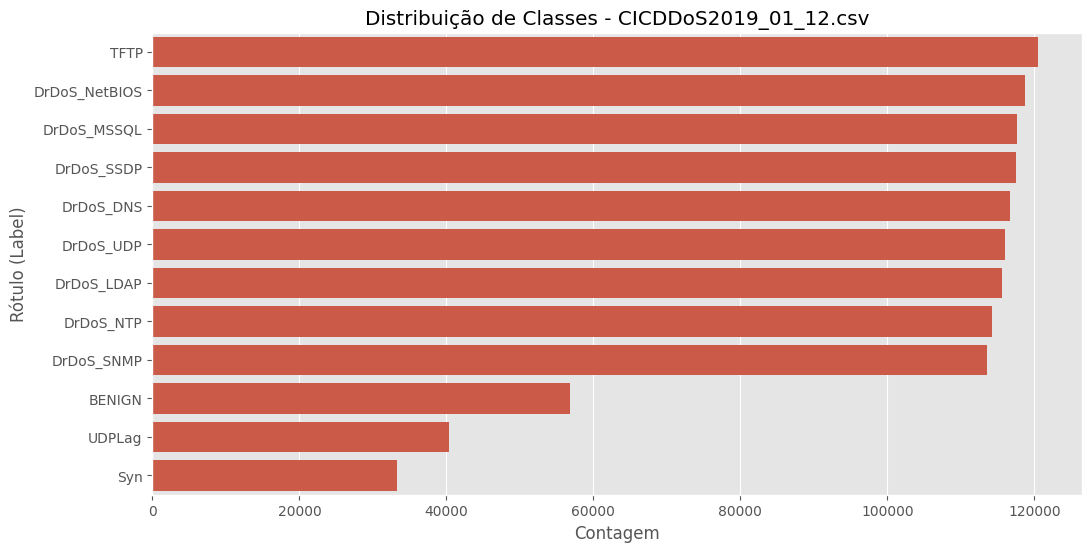

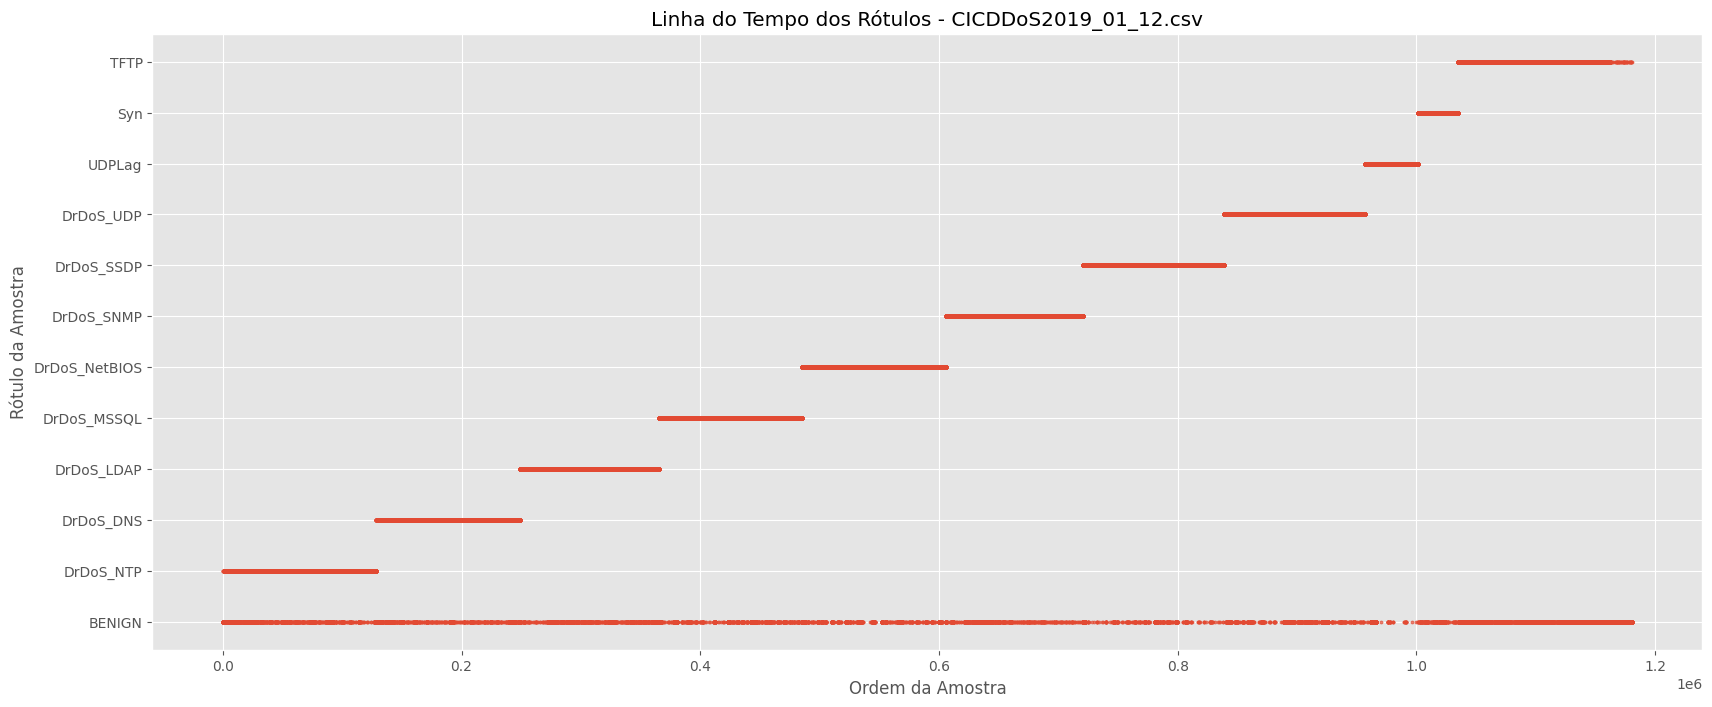

In [71]:
# --- Análise Exploratória do Dataset  ---
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 7) 
plt.style.use('ggplot') 

# --- Carregar o Dataset de Teste ---
# file = 'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'
# file = 'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
file = 'CICDDoS2019_01_12.csv'

df = pd.read_csv(file)

# --- Contagem de Rótulos ---
print(df['Label'].value_counts())

# --- Gráfico de Contagem de Rótulos ---
plt.figure(figsize=(12, 6))
sns.countplot(y=df['Label'], order=df['Label'].value_counts().index)
plt.title(f'Distribuição de Classes - {file}')
plt.xlabel('Contagem')
plt.ylabel('Rótulo (Label)')
plt.show()

# Ordenar o DataFrame pelo Timestamp e plotar o gráfico da linha do tempo
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df_sorted = df.sort_values(by='Timestamp')

# Resetar o index para que o eixo X do gráfico seja a ordem da amostra
df_sorted = df_sorted.reset_index(drop=True)

# --- Gráfico da Ordem dos Rótulos ---
plt.figure(figsize=(20, 8))
plt.scatter(df_sorted.index, df_sorted['Label'], s=5, alpha=0.7)
plt.title(f'Linha do Tempo dos Rótulos - {file}')
plt.xlabel('Ordem da Amostra')
plt.ylabel('Rótulo da Amostra')
plt.show()

## Análise dos Ataques

![Ataques](datasets/CICDDoS2019/img/ataques.png)

### DEVELOP CICDDoS2019

In [2]:
ARQUIVOS_ALVO = [
    'datasets\CICDDoS2019\data\CICDDoS2019_01_12_balanceado.csv',  
    'datasets\CICDDoS2019\data\CICDDoS2019_03_11_balanceado.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 2000263 linhas.


Label
Syn              123215
Portmap          121524
MSSQL            121234
TFTP             120511
UDPLag           119680
DrDoS_NetBIOS    118710
DrDoS_MSSQL      117590
DrDoS_SSDP       117479
NetBIOS          117459
UDP              117152
DrDoS_DNS        116641
DrDoS_UDP        115985
LDAP             115946
DrDoS_LDAP       115536
DrDoS_NTP        114251
BENIGN           113828
DrDoS_SNMP       113522
Name: count, dtype: int64

In [3]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 100000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN           5882
DrDoS_DNS        5882
DrDoS_LDAP       5882
DrDoS_MSSQL      5882
DrDoS_NTP        5882
DrDoS_NetBIOS    5882
DrDoS_SNMP       5882
DrDoS_SSDP       5882
DrDoS_UDP        5882
LDAP             5882
MSSQL            5882
NetBIOS          5882
Portmap          5882
Syn              5882
TFTP             5882
UDP              5882
UDPLag           5882
Name: count, dtype: int64

In [4]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Flow IAT Mean', 'Flow Packets/s', 'Flow Duration', 'Fwd IAT Total', 'act_data_pkt_fwd', 'Flow IAT Std', 'min_seg_size_forward', 'ACK Flag Count', 'Init_Win_bytes_forward', 'Flow Bytes/s', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Fwd Packet Length Min', 'Min Packet Length', 'Packet Length Mean', 'Average Packet Size', 'Fwd Packet Length Mean', 'Max Packet Length', 'Avg Fwd Segment Size', 'Fwd Packet Length Max']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


Flow IAT Mean  Flow Packets/s  Flow Duration  Fwd IAT Total  \
Label                                                                        
BENIGN          1.413435e-04    4.793191e-05   1.742543e-04   2.500005e-08   
DrDoS_DNS       2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
DrDoS_LDAP      2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
DrDoS_MSSQL     2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
DrDoS_NTP       4.896613e-07    1.084927e-02   8.308342e-06   8.308350e-06   
DrDoS_NetBIOS   2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
DrDoS_SNMP      4.069000e-08    2.500000e-01   1.666668e-08   1.666670e-08   
DrDoS_SSDP      9.765601e-07    1.041666e-02   4.083338e-07   4.083341e-07   
DrDoS_UDP       2.572286e-06    2.504369e-03   4.195838e-06   4.195842e-06   
LDAP            2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
MSSQL           2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
NetBIOS         2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
Portmap         2.034500e-08    5.000000e-01   8.333342e-09   8.333350e-09   
Syn             2.034500e-08    4.166667e-01   1.250001e-08   8.333350e-09   
TFTP            2.028572e-02    3.240887e-07   2.495821e-02   2.495823e-02   
UDP             1.015283e-05    5.343697e-04   5.297922e-05   5.297927e-05   
UDPLag          6.103500e-08    1.666667e-01   2.500003e-08   8.333350e-09   

               act_data_pkt_fwd  Flow IAT Std  min_seg_size_forward  \
Label                                                                 
BENIGN                 0.001984      0.000270              0.999999   
DrDoS_DNS              0.001984      0.000000              0.999999   
DrDoS_LDAP             0.001984      0.000000              0.999999   
DrDoS_MSSQL            0.001984      0.000000              0.999999   
DrDoS_NTP              0.077381      0.000001              0.999999   
DrDoS_NetBIOS          0.001984      0.000000              0.999999   
DrDoS_SNMP             0.001984      0.000000              0.999999   
DrDoS_SSDP             0.001984      0.000000              0.999999   
DrDoS_UDP              0.005952      0.000005              0.999999   
LDAP                   0.001984      0.000000              0.999999   
MSSQL                  0.001984      0.000000              0.999999   
NetBIOS                0.001984      0.000000              0.999999   
Portmap                0.001984      0.000000              0.999999   
Syn                    0.001984      0.000000              0.999999   
TFTP                   0.005952      0.035619              0.999999   
UDP                    0.005952      0.000021              0.999999   
UDPLag                 0.001984      0.000000              0.999999   

               ACK Flag Count  Init_Win_bytes_forward  Flow Bytes/s  \
Label                                                                 
BENIGN                    0.0                0.003891  2.174388e-06   
DrDoS_DNS                 0.0                0.000000  9.945652e-01   
DrDoS_LDAP                0.0                0.000000  1.000000e+00   
DrDoS_MSSQL               0.0                0.000000  3.104620e-01   
DrDoS_NTP                 0.0                0.000000  6.278315e-03   
DrDoS_NetBIOS             0.0                0.000000  1.555707e-01   
DrDoS_SNMP                0.0                0.000000  5.000000e-01   
DrDoS_SSDP                0.0                0.000000  5.420328e-03   
DrDoS_UDP                 0.0                0.000000  1.417211e-03   
LDAP                      0.0                0.000000  1.000000e+00   
MSSQL                     0.0                0.000000  3.050272e-01   
NetBIOS                   0.0                0.000000  1.555707e-01   
Portmap                   0.0                0.000000  1.555707e-01   
Syn                       1.0                0.089127  8.318545e-05   
TFTP                      0.0                0

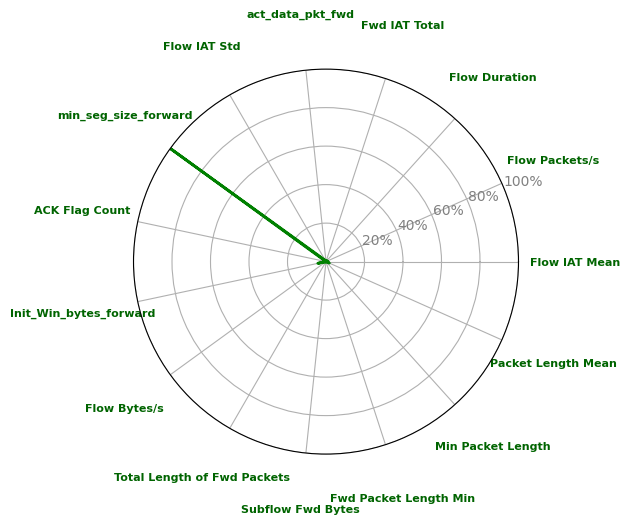

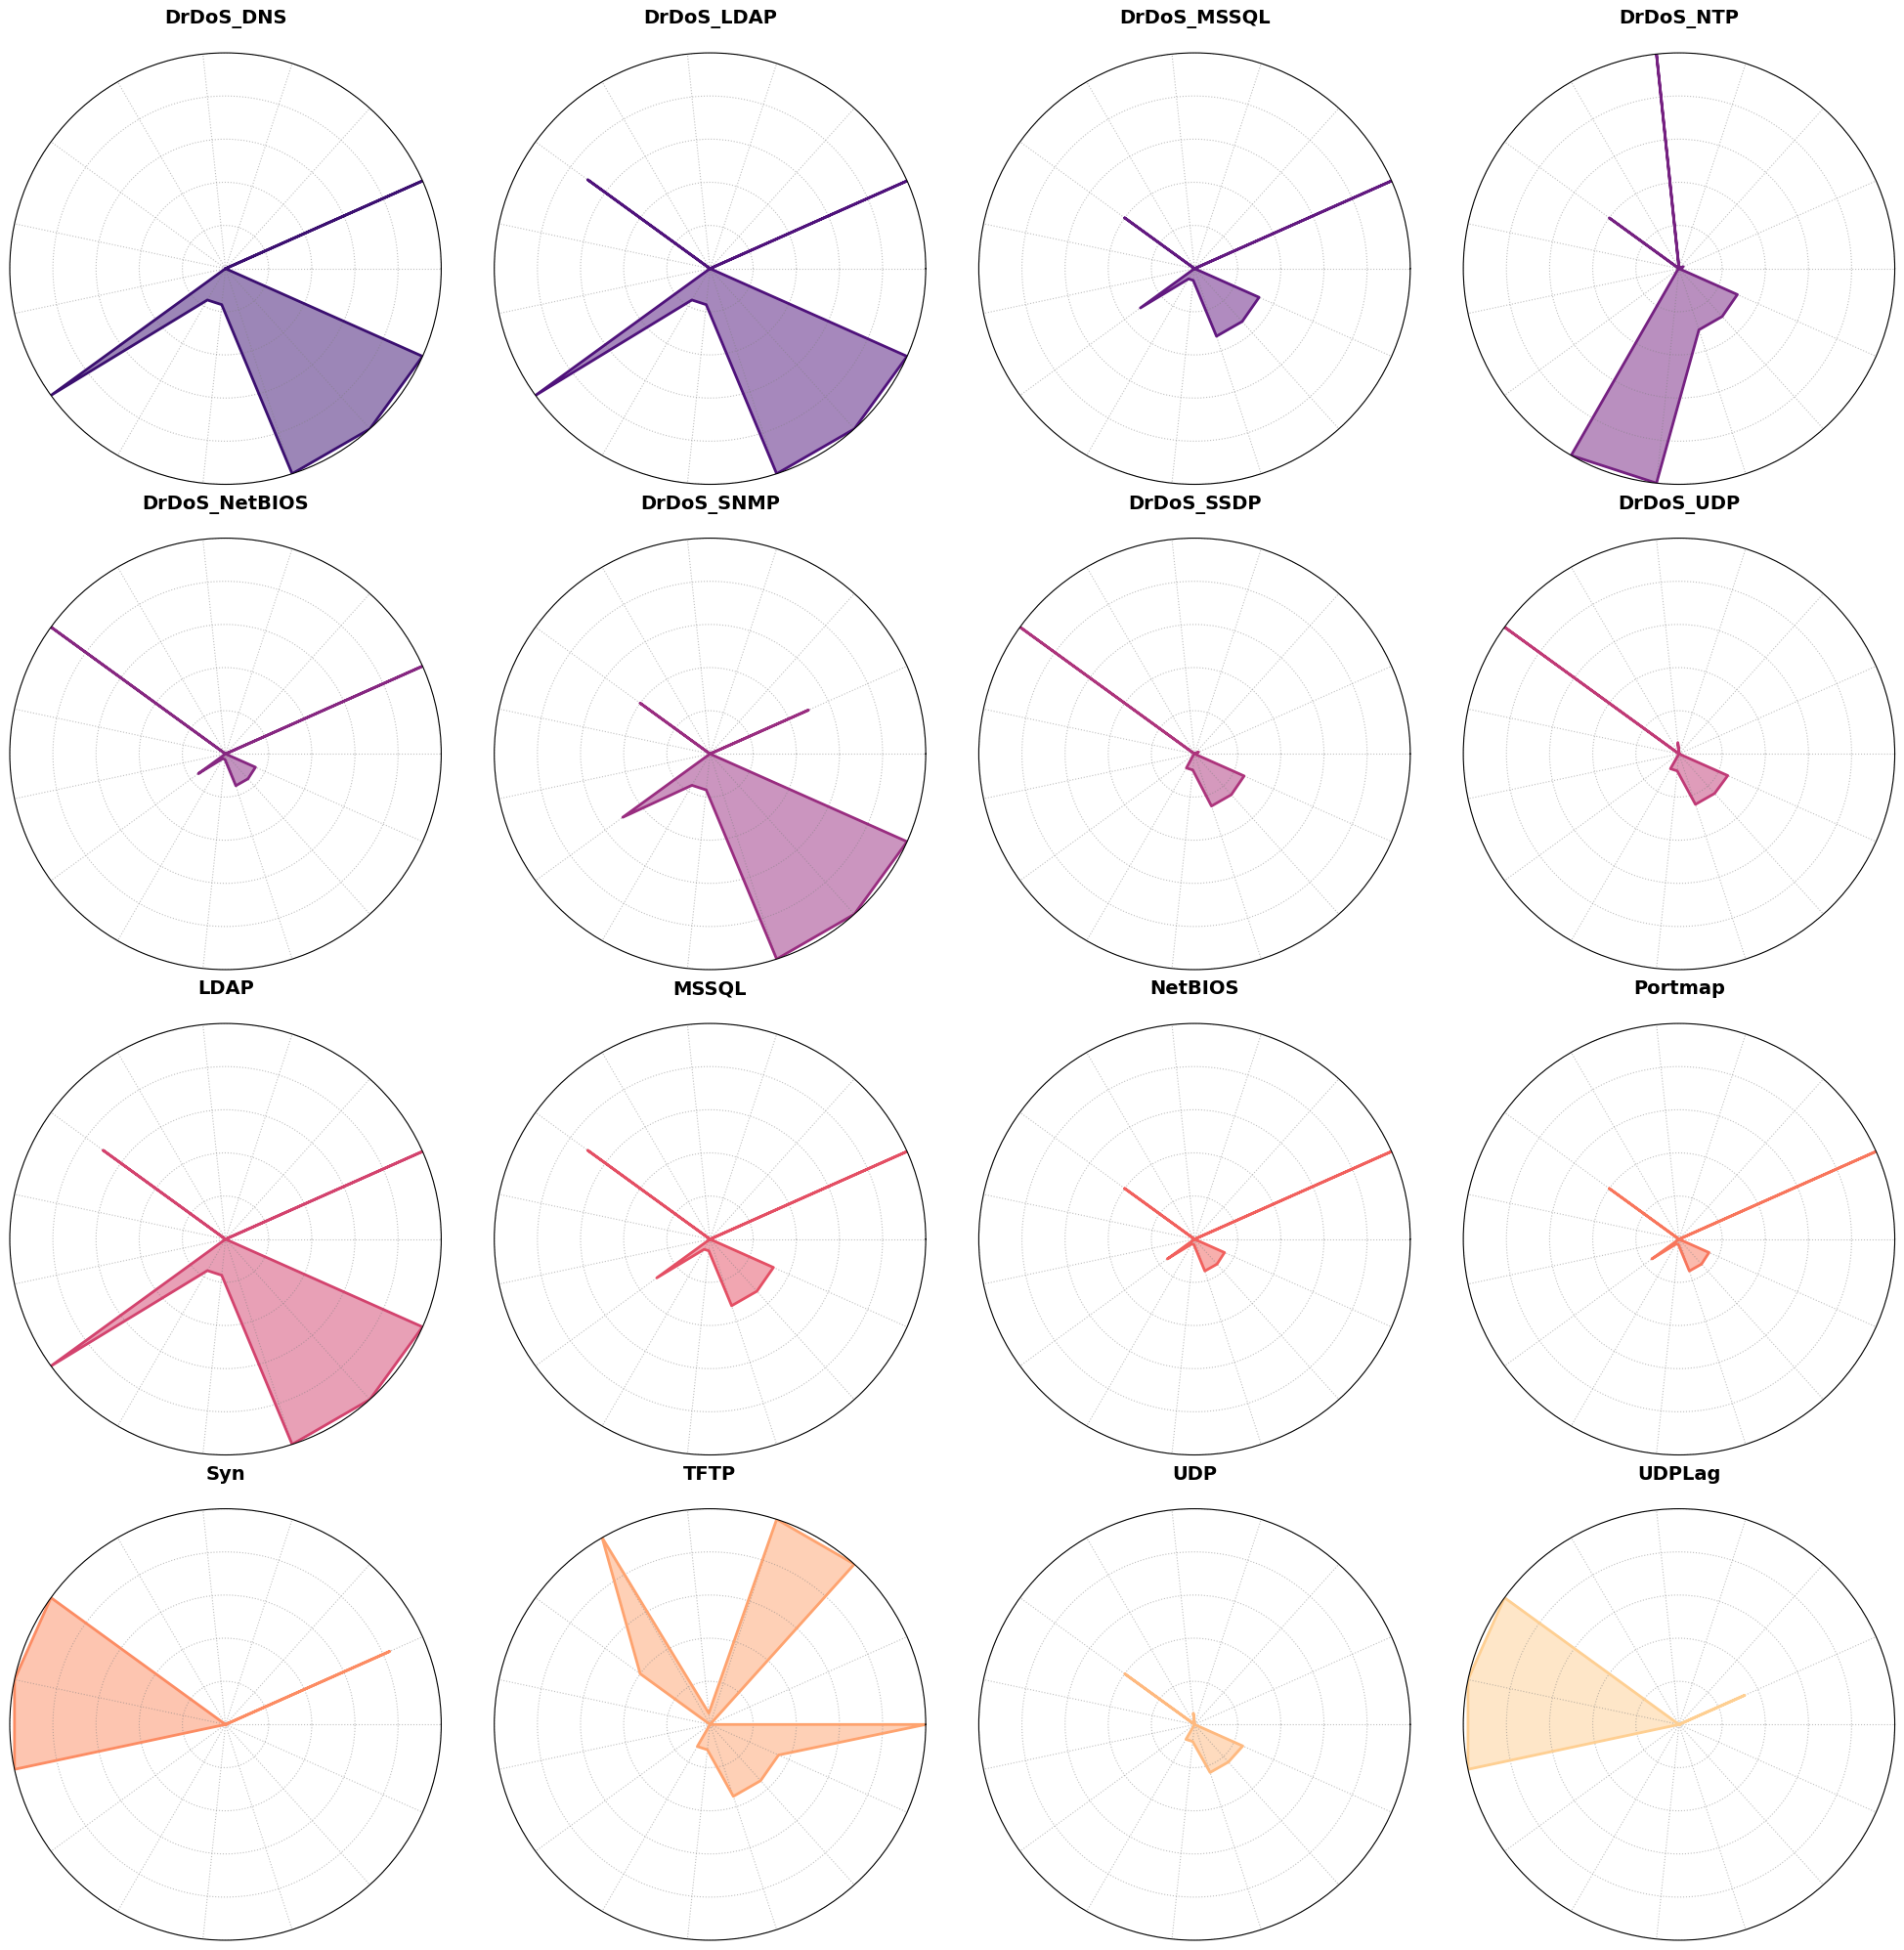

In [ ]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares(df_radar_ready, features_para_plotar)

Corte utilizado: 0.77
Métrica: MANHATTAN
Ligação: AVERAGE


Qtd                                      Ataques Manhattan  \
0    4      DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP    0.3759   
1    5  DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP    0.4297   
2    3              DrDoS_NetBIOS, NetBIOS, Portmap    0.0000   
3    2                           DrDoS_MSSQL, MSSQL    0.0316   
4    2                                  Syn, UDPLag    0.2500   
5    1                                       BENIGN     Único   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
2                  min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min  
3                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min  
4               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
5   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean

Corte utilizado: 1.08
Métrica: MANHATTAN
Ligação: COMPLETE


Qtd                                              Ataques Manhattan  \
0    4              DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP    0.3759   
1    2                                          Syn, UDPLag    0.2500   
2    1                                               BENIGN     Único   
3    5          DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP    0.4297   
4    5  DrDoS_MSSQL, DrDoS_NetBIOS, MSSQL, NetBIOS, Portmap    0.5911   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
2   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean  
3  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
4                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min

Corte utilizado: 0.80
Métrica: MANHATTAN
Ligação: MEDIAN


Qtd                                      Ataques Manhattan  \
0    4      DrDoS_DNS, DrDoS_LDAP, DrDoS_SNMP, LDAP    0.3759   
1    5  DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP    0.4297   
2    3              DrDoS_NetBIOS, NetBIOS, Portmap    0.0000   
3    2                           DrDoS_MSSQL, MSSQL    0.0316   
4    2                                  Syn, UDPLag    0.2500   
5    1                                       BENIGN     Único   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
2                  min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min  
3                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min  
4               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
5   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean

Corte utilizado: 0.27
Métrica: EUCLIDIANA
Ligação: AVERAGE


Qtd                                      Ataques Euclidiana  \
0    3                  DrDoS_DNS, DrDoS_LDAP, LDAP     0.0036   
1    1                                   DrDoS_SNMP      Único   
2    2                                  Syn, UDPLag     0.2500   
3    3              DrDoS_NetBIOS, NetBIOS, Portmap     0.0000   
4    2                           DrDoS_MSSQL, MSSQL     0.0114   
5    5  DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP     0.1510   
6    1                                       BENIGN      Único   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1  Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size  
2               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
3                  min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min  
4                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min  
5  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
6   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean

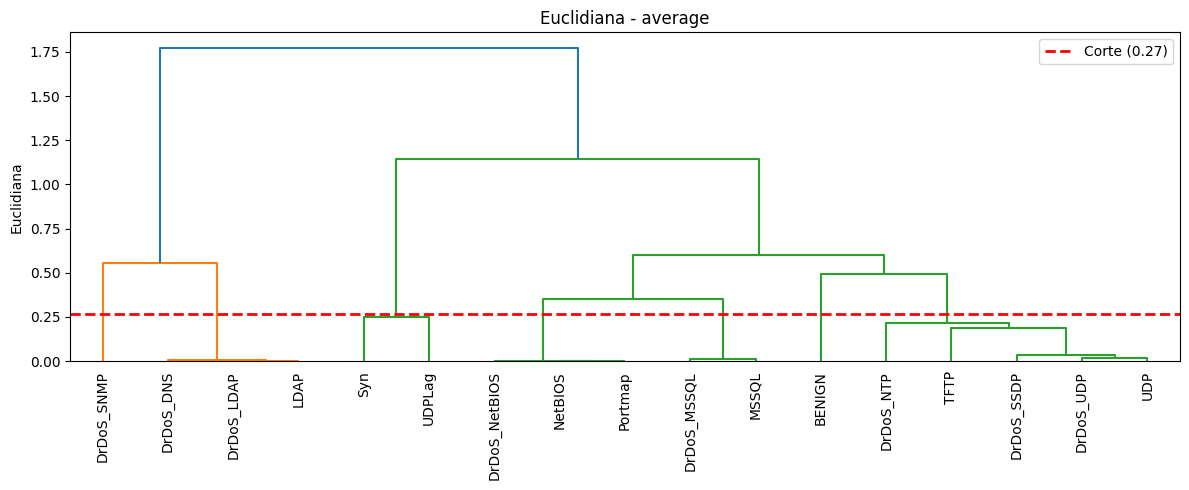

Corte utilizado: 0.35
Métrica: EUCLIDIANA
Ligação: COMPLETE


Qtd                                      Ataques Euclidiana  \
0    3                  DrDoS_DNS, DrDoS_LDAP, LDAP     0.0036   
1    1                                   DrDoS_SNMP      Único   
2    2                                  Syn, UDPLag     0.2500   
3    3              DrDoS_NetBIOS, NetBIOS, Portmap     0.0000   
4    2                           DrDoS_MSSQL, MSSQL     0.0114   
5    5  DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP     0.1510   
6    1                                       BENIGN      Único   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1  Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size  
2               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
3                  min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min  
4                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min  
5  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
6   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean

Corte utilizado: 0.28
Métrica: EUCLIDIANA
Ligação: MEDIAN


Qtd                                      Ataques Euclidiana  \
0    3                  DrDoS_DNS, DrDoS_LDAP, LDAP     0.0036   
1    1                                   DrDoS_SNMP      Único   
2    2                                  Syn, UDPLag     0.2500   
3    3              DrDoS_NetBIOS, NetBIOS, Portmap     0.0000   
4    2                           DrDoS_MSSQL, MSSQL     0.0114   
5    5  DrDoS_NTP, DrDoS_SSDP, DrDoS_UDP, TFTP, UDP     0.1510   
6    1                                       BENIGN      Único   

                                                                                                     Assinatura  
0          Min Packet Length, min_seg_size_forward, Flow Bytes/s, Fwd Packet Length Min, Fwd Packet Length Mean  
1  Min Packet Length, min_seg_size_forward, Fwd Packet Length Min, Fwd Packet Length Mean, Avg Fwd Segment Size  
2               ACK Flag Count, min_seg_size_forward, Flow Packets/s, Init_Win_bytes_forward, Min Packet Length  
3                  min_seg_size_forward, Flow Packets/s, Flow Bytes/s, Min Packet Length, Fwd Packet Length Min  
4                  min_seg_size_forward, Flow Packets/s, Min Packet Length, Flow Bytes/s, Fwd Packet Length Min  
5  min_seg_size_forward, Min Packet Length, Fwd Packet Length Mean, Avg Fwd Segment Size, Fwd Packet Length Min  
6   min_seg_size_forward, Fwd Packet Length Mean, Avg Fwd Segment Size, Average Packet Size, Packet Length Mean

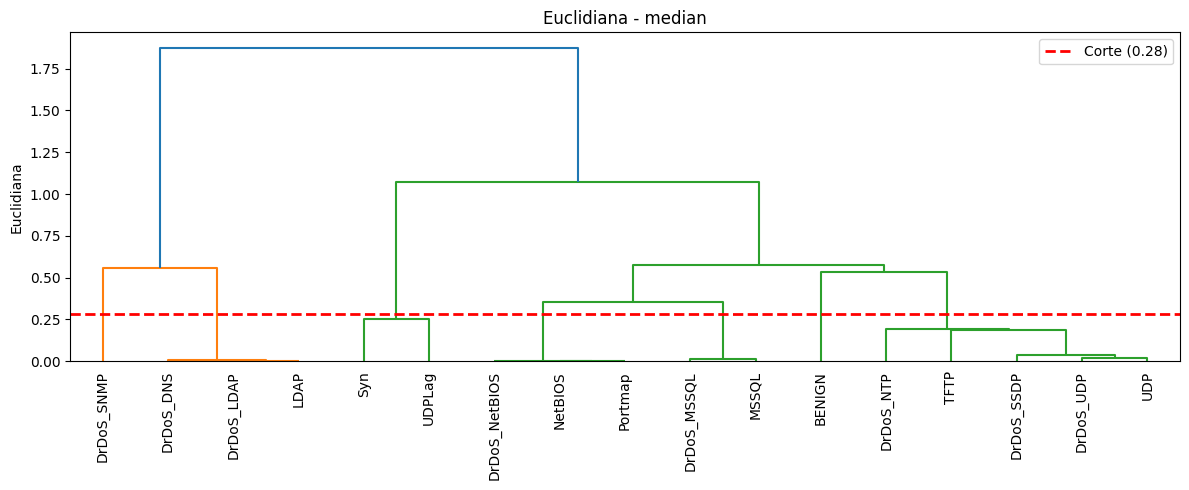

In [12]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean'),
]

config_linkage = ['average', 'complete', 'median']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa
    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.15 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"{nome_metrica} - {metodo_link}")
        plt.ylabel(f"{tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

### DEVELOP CIC-IDS-2017

In [22]:
ARQUIVOS_ALVO = [
    'datasets\CIC-IDS-2017\Wednesday-workingHours.pcap_ISCX.csv',  
    'datasets\CIC-IDS-2017\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'     
]

df = carregar_e_unificar(ARQUIVOS_ALVO, 100000)
df.value_counts("Label")

Iniciando processamento integral de 2 arquivos...
Dataset Unificado Pronto: 918448 linhas.


Label
BENIGN              537749
DoS Hulk            231073
DDoS                128027
DoS GoldenEye        10293
DoS slowloris         5796
DoS Slowhttptest      5499
Heartbleed              11
Name: count, dtype: int64

In [23]:
print("1. Preparação dos Dados")

TAMANHO_AMOSTRA = 40000

# Amostragem Estratificada Segura
n_por_grupo = TAMANHO_AMOSTRA // len(df['Label'].unique())

df = df[df['Label'] != 'Heartbleed']

df_amostra = df.groupby('Label').apply(
    lambda x: x.sample(n=min(len(x), n_por_grupo), random_state=42),
    include_groups=False 
).reset_index(level=0)

X_raw = df_amostra.drop(columns=['Label'])
y = df_amostra['Label']

# Limpeza e Normalização
X_numeric = X_raw.select_dtypes(include=[np.number]).copy()
X_numeric.replace([np.inf, -np.inf], np.nan, inplace=True)
X_numeric.fillna(X_numeric.median(), inplace=True)

scaler = MinMaxScaler() 
X_trans = scaler.fit_transform(X_numeric)
labels_unique = y.unique()

df_amostra.value_counts("Label")

1. Preparação dos Dados


Label
BENIGN              5714
DDoS                5714
DoS GoldenEye       5714
DoS Hulk            5714
DoS slowloris       5714
DoS Slowhttptest    5499
Name: count, dtype: int64

In [24]:
print("2. Seleção de Features e Extração de DNA Comportamental")

rf_sel = RandomForestClassifier(n_estimators=100, max_depth=15, n_jobs=-1, random_state=42)
le = LabelEncoder()
y_num = le.fit_transform(y)

# O X_trans agora já está entre 0 e 1 (correto)
rf_sel.fit(X_trans, y_num)

importancias = rf_sel.feature_importances_
indices_top = np.argsort(importancias)[-20:] 
feature_names_final = X_numeric.columns[indices_top]

print(f"Features Selecionadas: {list(feature_names_final)}")

print(" > Calculando perfil típico de cada ataque...")

# Filtramos o dataset original (já normalizado Globalmente)
X_top_features = pd.DataFrame(X_trans, columns=X_numeric.columns).iloc[:, indices_top]
X_top_features['Label'] = y.values

# Calculamos a MEDIANA. 
df_final_sig = X_top_features.groupby('Label').median()

print(" > Matriz de Assinaturas (Comportamental) Gerada!")
display(df_final_sig)

2. Seleção de Features e Extração de DNA Comportamental
Features Selecionadas: ['Bwd Packet Length Max', 'Subflow Bwd Bytes', 'Fwd Packet Length Mean', 'Fwd IAT Mean', 'Flow Packets/s', 'Bwd Header Length', 'Packet Length Mean', 'Flow IAT Std', 'Total Length of Fwd Packets', 'Subflow Fwd Bytes', 'Bwd Packet Length Mean', 'Max Packet Length', 'Active Min', 'Flow IAT Mean', 'Total Length of Bwd Packets', 'Bwd Packet Length Std', 'Avg Bwd Segment Size', 'Fwd Packet Length Max', 'Init_Win_bytes_forward', 'min_seg_size_forward']
 > Calculando perfil típico de cada ataque...
 > Matriz de Assinaturas (Comportamental) Gerada!


Bwd Packet Length Max  Subflow Bwd Bytes  \
Label                                                        
BENIGN                         0.007050           0.000048   
DDoS                           0.376547           0.004190   
DoS GoldenEye                  0.373453           0.004201   
DoS Hulk                       0.373453           0.004188   
DoS Slowhttptest               0.000000           0.000000   
DoS slowloris                  0.000000           0.000000   

                  Fwd Packet Length Mean  Fwd IAT Mean  Flow Packets/s  \
Label                                                                    
BENIGN                          0.013291  3.333333e-08    2.849237e-05   
DDoS                            0.002412  4.224943e-03    8.251223e-07   
DoS GoldenEye                   0.018166  9.609017e-03    3.192987e-07   
DoS Hulk                        0.015812  1.025000e-01    4.875918e-08   
DoS Slowhttptest                0.000000  8.750000e-02    3.139850e-08   
DoS slowloris                   0.002757  5.869524e-02    5.437660e-08   

                  Bwd Header Length  Packet Length Mean  Flow IAT Std  \
Label                                                                   
BENIGN                     0.000864            0.028250      0.000003   
DDoS                       0.001987            0.383700      0.011993   
DoS GoldenEye              0.003628            0.257832      0.025130   
DoS Hulk                   0.004319            0.366652      0.290598   
DoS Slowhttptest           0.000000            0.000000      0.145299   
DoS slowloris              0.001382            0.002332      0.152625   

                  Total Length of Fwd Packets  Subflow Fwd Bytes  \
Label                                                              
BENIGN                               0.000256           0.000256   
DDoS                                 0.000095           0.000095   
DoS GoldenEye                        0.001382           0.001382   
DoS Hulk                             0.001214           0.001214   
DoS Slowhttptest                     0.000000           0.000000   
DoS slowloris                        0.000059           0.000059   

                  Bwd Packet Length Mean  Max Packet Length    Active Min  \
Label                                                                       
BENIGN                          0.019601           0.008425  0.000000e+00   
DDoS                            0.498925           0.376547  0.000000e+00   
DoS GoldenEye                   0.375000           0.373453  5.467153e-05   
DoS Hulk                        0.427208           0.373453  4.379562e-07   
DoS Slowhttptest                0.000000           0.000000  5.112655e-01   
DoS slowloris                   0.000000           0.000688  3.211679e-06   

                  Flow IAT Mean  Total Length of Bwd Packets  \
Label                                                          
BENIGN                 0.000134                     0.000048   
DDoS                   0.004225                     0.004190   
DoS GoldenEye          0.009470                     0.004201   
DoS Hulk               0.055009                     0.004188   
DoS Slowhttptest       0.087500                     0.000000   
DoS slowloris          0.048910                     0.000000   

                  Bwd Packet Length Std  Avg Bwd Segment Size  \
Label                                                           
BENIGN                         0.000000              0.019601   
DDoS                           0.326066              0.498925   
DoS GoldenEye                  0.262443              0.375000   
DoS Hulk                       0.262160              0.427208   
DoS Slowhttptest               0.000000              0.000000   
DoS slowloris                  0.000000              0.000000   

                  Fwd Packet Length Max  Init_Win_bytes_forward  \
Label                                                             
BENIGN       

In [ ]:
features_para_plotar = df_final_sig.columns[:15].tolist() 

df_radar_ready = df_final_sig.copy()
df_radar_ready = df_radar_ready.reset_index() 
df_radar_ready = df_radar_ready.rename(columns={'index': 'Label'})

visualizar_radares(df_radar_ready, features_para_plotar)

Corte utilizado: 1.21
Métrica: MANHATTAN
Ligação: AVERAGE


Qtd                          Ataques Manhattan  \
0    3    DDoS, DoS GoldenEye, DoS Hulk    1.0523   
1    2  DoS Slowhttptest, DoS slowloris    0.7368   
2    1                           BENIGN     Único   

                                                                                                       Assinatura  
0    min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length  
1                            min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean  
2  min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean

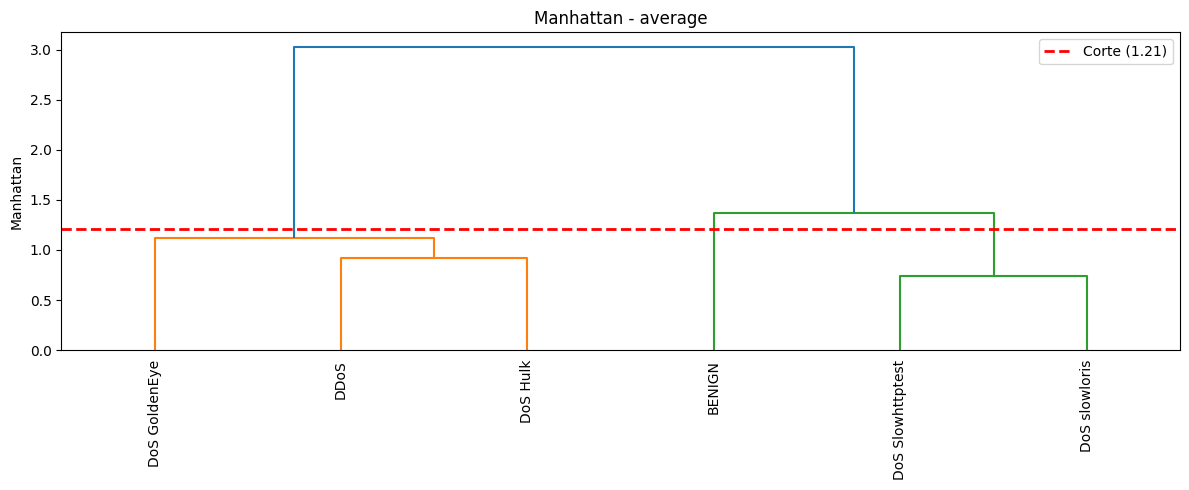

Corte utilizado: 1.63
Métrica: MANHATTAN
Ligação: COMPLETE


Qtd                          Ataques Manhattan  \
0    3    DDoS, DoS GoldenEye, DoS Hulk    1.0523   
1    2  DoS Slowhttptest, DoS slowloris    0.7368   
2    1                           BENIGN     Único   

                                                                                                       Assinatura  
0    min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length  
1                            min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean  
2  min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean

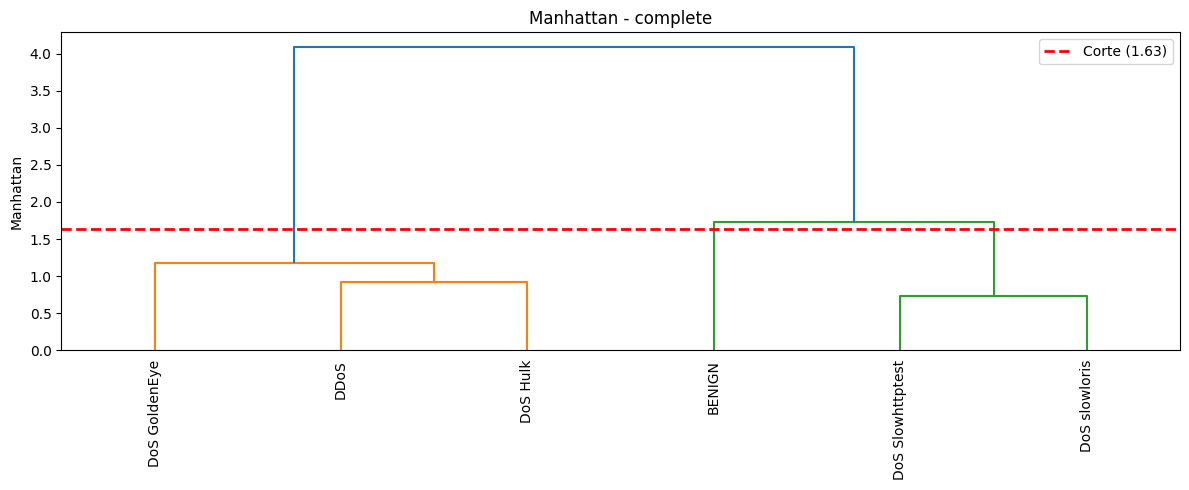

Corte utilizado: 1.10
Métrica: MANHATTAN
Ligação: MEDIAN


Qtd                          Ataques Manhattan  \
0    3    DDoS, DoS GoldenEye, DoS Hulk    1.0523   
1    2  DoS Slowhttptest, DoS slowloris    0.7368   
2    1                           BENIGN     Único   

                                                                                                       Assinatura  
0    min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length  
1                            min_seg_size_forward, Init_Win_bytes_forward, Active Min, Flow IAT Std, Fwd IAT Mean  
2  min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean

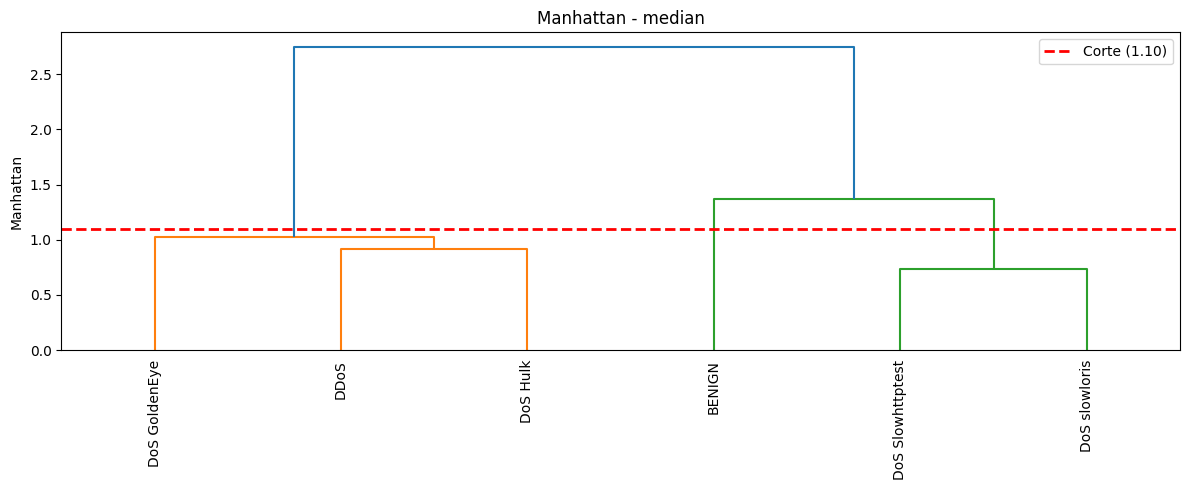

Corte utilizado: 0.42
Métrica: EUCLIDIANA
Ligação: AVERAGE


Qtd           Ataques Euclidiana  \
0    2    DDoS, DoS Hulk     0.3890   
1    1     DoS GoldenEye      Único   
2    1            BENIGN      Único   
3    1     DoS slowloris      Único   
4    1  DoS Slowhttptest      Único   

                                                                                                          Assinatura  
0      min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max  
1  min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max  
2     min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean  
3                            min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean  
4                               min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean

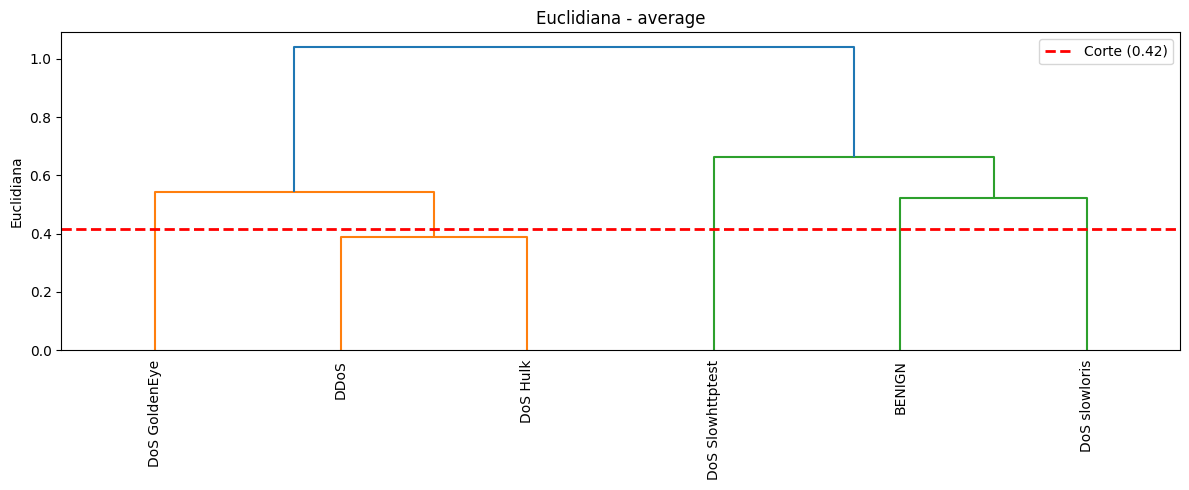

Corte utilizado: 0.51
Métrica: EUCLIDIANA
Ligação: COMPLETE


Qtd           Ataques Euclidiana  \
0    2    DDoS, DoS Hulk     0.3890   
1    1     DoS GoldenEye      Único   
2    1            BENIGN      Único   
3    1     DoS slowloris      Único   
4    1  DoS Slowhttptest      Único   

                                                                                                          Assinatura  
0      min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max  
1  min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max  
2     min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean  
3                            min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean  
4                               min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean

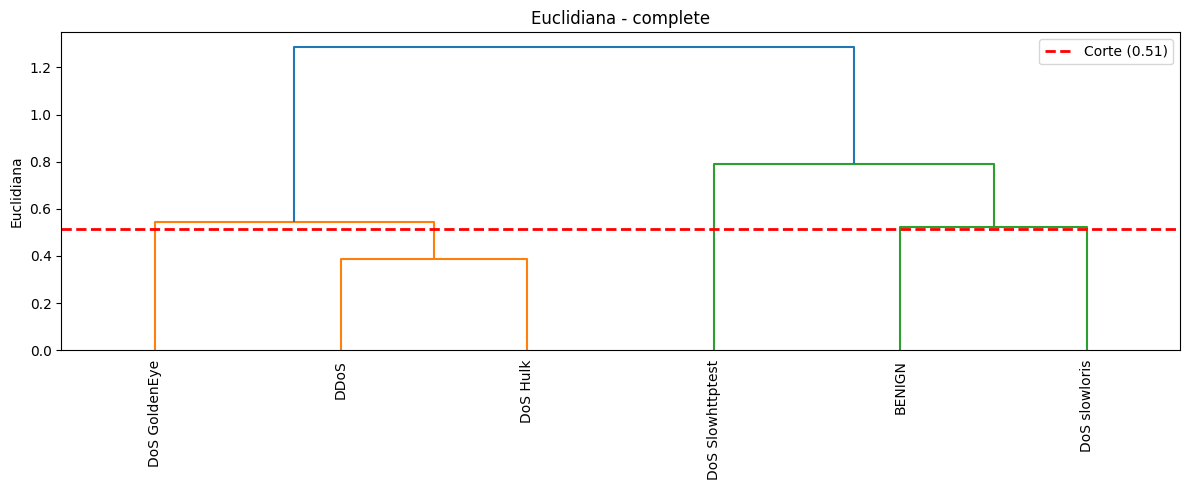

Corte utilizado: 0.37
Métrica: EUCLIDIANA
Ligação: MEDIAN


Qtd           Ataques Euclidiana  \
0    1              DDoS      Único   
1    1          DoS Hulk      Único   
2    1     DoS GoldenEye      Único   
3    1            BENIGN      Único   
4    1     DoS slowloris      Único   
5    1  DoS Slowhttptest      Único   

                                                                                                          Assinatura  
0         Bwd Packet Length Mean, Avg Bwd Segment Size, Packet Length Mean, Bwd Packet Length Max, Max Packet Length  
1       min_seg_size_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max, Max Packet Length  
2  min_seg_size_forward, Init_Win_bytes_forward, Bwd Packet Length Mean, Avg Bwd Segment Size, Bwd Packet Length Max  
3     min_seg_size_forward, Packet Length Mean, Bwd Packet Length Mean, Avg Bwd Segment Size, Fwd Packet Length Mean  
4                            min_seg_size_forward, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean, Flow IAT Mean  
5                               min_seg_size_forward, Active Min, Init_Win_bytes_forward, Flow IAT Std, Fwd IAT Mean

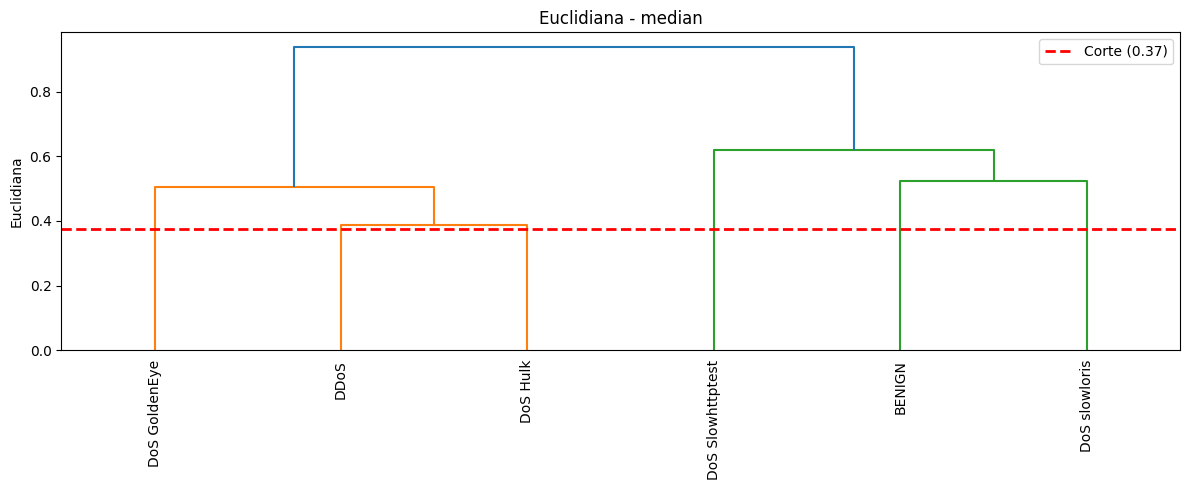

In [26]:
config_metricas = [
    ('Manhattan', 'cityblock'),
    ('Euclidiana', 'euclidean')
]

config_linkage = ['average', 'complete', 'median']

for nome_metrica, str_metrica in config_metricas:
    # Calcula a matriz de distância condensada nativa

    dist_condensada_atual = pdist(df_final_sig, metric=str_metrica)
    # Converte para matriz quadrada para podermos calcular a média interna do grupo depois
    matriz_distancia_full = squareform(dist_condensada_atual)

    for metodo_link in config_linkage:
        # Hierarquia
        Z = linkage(dist_condensada_atual, method=metodo_link)

        # Definição do Corte 
        corte = 0.40 * max(Z[:, 2])
        lbl_corte = f"{corte:.2f}"
        tipo_medida = f"{nome_metrica}"

        # Clusterização
        final_labels = fcluster(Z, t=corte, criterion='distance')

        # Relatório 
        report = []
        for cid in sorted(set(final_labels)):
            membros = df_final_sig.index[final_labels == cid].tolist()
            indices_membros = np.where(final_labels == cid)[0]
            
            if len(membros) > 1:
                # Se tem grupo, calcula a média real
                sub_matriz = matriz_distancia_full[np.ix_(indices_membros, indices_membros)]
                valores_distancia = sub_matriz[np.triu_indices(len(membros), k=1)]
                media_distancia = valores_distancia.mean()
                
                # Formata o valor
                if str_metrica == 'cosine':
                    val_display = 1 - media_distancia # Converte dist volta para similaridade
                    val_str = f"{val_display:.4f}"
                else:
                    val_str = f"{media_distancia:.4f}"
            else:
                # Se for item único, não calculamos média (para não dar 1.0 ou 0.0 enganoso)
                val_str = "Único"

            # Assinatura
            avg_imp = df_final_sig.loc[membros].mean()
            top_feats = avg_imp.nlargest(5).index.tolist()
            
            report.append({
                'Qtd': len(membros),
                'Ataques': ", ".join(membros),
                f'{tipo_medida}': val_str,
                'Assinatura': ", ".join(top_feats)
            })
        
        # Exibir Tabela
        print(f"Corte utilizado: {lbl_corte}")
        print(f"Métrica: {nome_metrica.upper()}")
        print(f"Ligação: {metodo_link.upper()}")
        display(pd.DataFrame(report))

        # Plotar Dendrograma
        plt.figure(figsize=(12, 5))
        dendrogram(Z, labels=labels_unique, leaf_rotation=90., leaf_font_size=10.)
        plt.axhline(y=corte, c='r', ls='--', lw=2, label=f'Corte ({corte:.2f})')
        plt.title(f"{nome_metrica} - {metodo_link}")
        plt.ylabel(f"{tipo_medida}")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Criação dos cenários de Teste

## CICDDoS2019

### Análise Individual dos arquivos csv

In [4]:
def analisar_dataset(path):
    global_start, global_end = None, None
    benign_start, benign_end = None, None
    attack_start, attack_end = None, None
    
    count_benign = 0
    count_attack = 0
    
    # Granularidade
    rows_same_timestamp_max = 0
    time_diffs = set()
    
    print(f"--- Iniciando Análise de {path} ---")
    for i, chunk in enumerate(pd.read_csv(path, chunksize=100000, low_memory=False)):
        
        # Limpeza de nomes de colunas 
        chunk.columns = chunk.columns.str.strip()
        
        # Conversão de Timestamp
        if 'Timestamp' in chunk.columns:
            chunk['Timestamp'] = pd.to_datetime(chunk['Timestamp'])
        
        # Análise Global
        c_min = chunk['Timestamp'].min()
        c_max = chunk['Timestamp'].max()
        
        if global_start is None or c_min < global_start: global_start = c_min
        if global_end is None or c_max > global_end: global_end = c_max
            
        # Separação por Classe
        mask_benign = chunk['Label'] == 'BENIGN'
        df_benign = chunk[mask_benign]
        df_attack = chunk[~mask_benign]
        
        count_benign += len(df_benign)
        count_attack += len(df_attack)
        
        # Análise Benigno
        if not df_benign.empty:
            b_min = df_benign['Timestamp'].min()
            b_max = df_benign['Timestamp'].max()
            if benign_start is None or b_min < benign_start: benign_start = b_min
            if benign_end is None or b_max > benign_end: benign_end = b_max
            
        # Análise Ataque
        if not df_attack.empty:
            a_min = df_attack['Timestamp'].min()
            a_max = df_attack['Timestamp'].max()
            if attack_start is None or a_min < attack_start: attack_start = a_min
            if attack_end is None or a_max > attack_end: attack_end = a_max

        # Granularidade
        top_freq = chunk['Timestamp'].value_counts().max()
        if top_freq > rows_same_timestamp_max:
            rows_same_timestamp_max = top_freq
            
        print(f"Processando Chunk {i+1}... (Benignos: {count_benign} | Ataques: {count_attack})", end='\r')

    # Cálculo das Durações
    duracao_total = global_end - global_start if global_end else pd.Timedelta(0)
    duracao_benign = (benign_end - benign_start) if benign_end else pd.Timedelta(0)
    duracao_attack = (attack_end - attack_start) if attack_end else pd.Timedelta(0)

    print("\n\n")
    print(f"1. ARQUIVO COMPLETO")
    print(f"   Início:  {global_start}")
    print(f"   Fim:     {global_end}")
    print(f"   Duração: {duracao_total}")
    print("-" * 30)
    
    print(f"2. FLUXO NORMAL")
    print(f"   Início:  {benign_start}")
    print(f"   Fim:     {benign_end}")
    print(f"   Duração: {duracao_benign}")
    print(f"   Amostras: {count_benign}")
    print("-" * 30)
    
    print(f"3. FLUXO DE ATAQUE")
    print(f"   Início:  {attack_start}")
    print(f"   Fim:     {attack_end}")
    print(f"   Duração: {duracao_attack}")
    print(f"   Amostras: {count_attack}")
    print("-" * 30)
    
    print(f"4. ANÁLISE DE SOBREPOSIÇÃO")
    sobreposicao = False
    if benign_start and attack_start:
        if (attack_start <= benign_end) and (attack_end >= benign_start):
            sobreposicao = True
            print("   [ALERTA] Os fluxos Benigno e Ataque ocorrem SIMULTANEAMENTE.")
    else:
        print("   Não houve sobreposição detectada ou uma das classes está ausente.")

In [5]:
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
analisar_dataset(file_path)

--- Iniciando Análise de datasets/CICDDoS2019/01-12/DrDoS_DNS.csv ---
Processando Chunk 51... (Benignos: 3402 | Ataques: 5071011)


1. ARQUIVO COMPLETO
   Início:  2018-12-01 10:51:39.813448
   Fim:     2018-12-01 11:22:40.254719
   Duração: 0 days 00:31:00.441271
------------------------------
2. FLUXO NORMAL
   Início:  2018-12-01 10:51:40.379825
   Fim:     2018-12-01 11:22:19.811888
   Duração: 0 days 00:30:39.432063
   Amostras: 3402
------------------------------
3. FLUXO DE ATAQUE
   Início:  2018-12-01 10:51:39.813448
   Fim:     2018-12-01 11:22:40.254719
   Duração: 0 days 00:31:00.441271
   Amostras: 5071011
------------------------------
4. ANÁLISE DE SOBREPOSIÇÃO
   [ALERTA] Os fluxos Benigno e Ataque ocorrem SIMULTANEAMENTE.


### Criação de um arquivo CSV com as amostras normais 

In [6]:
# input_folder = 'datasets/CICDDoS2019/01-12'
# output_folder = 'datasets/CICDDoS2019/data'
# output_file = 'benign_0112.csv'

input_folder = 'datasets/CICDDoS2019/03-11'
output_folder = 'datasets/CICDDoS2019/data'
output_file = 'benign_0311.csv'


# Cria a pasta de saída se não existir
os.makedirs(output_folder, exist_ok=True)

# Lista todos os arquivos .csv da pasta
all_files = glob.glob(os.path.join(input_folder, "*.csv"))

# Lista para armazenar temporariamente os DataFrames apenas com dados benignos
benign_data = []

print(f"Iniciando processamento de {len(all_files)} arquivos...")

for filename in all_files:
    print(f"Lendo: {os.path.basename(filename)}...")
    
    try:
        for chunk in pd.read_csv(filename, chunksize=100000, low_memory=False):
            # Remoção dos espaços nas colunas
            chunk.columns = chunk.columns.str.strip()
            
            # Coleta todas as amostras benign 
            benign_chunk = chunk[chunk['Label'] == 'BENIGN']
            
            # Se houver dados benignos nesse chunk, adiciona à lista
            if not benign_chunk.empty:
                benign_data.append(benign_chunk)
                
    except Exception as e:
        print(f"Erro ao ler {filename}: {e}")

    print(f"Finalizado arquivo: {os.path.basename(filename)}")

# Verifica se coletou dados
if benign_data:
    # Concatena todos os pedaços benignos em um único DataFrame
    full_benign_df = pd.concat(benign_data)
    
    # Ordenar pelo Timestamp
    try:
        full_benign_df['Timestamp'] = pd.to_datetime(full_benign_df['Timestamp'])
    except:
        pass # Se falhar, mantém como está
        
    full_benign_df = full_benign_df.sort_values(by='Timestamp')
    
    # Salvar em arquivo csv
    output_path = os.path.join(output_folder, output_file)
    full_benign_df.to_csv(output_path, index=False)
    
    print(f"Concluído! Arquivo salvo em: {output_path}")
    print(f"Total de amostras benignas: {len(full_benign_df)}")

else:
    print("Nenhuma amostra benigna foi encontrada nos arquivos.")

Iniciando processamento de 7 arquivos...
Lendo: LDAP.csv...
Finalizado arquivo: LDAP.csv
Lendo: MSSQL.csv...
Finalizado arquivo: MSSQL.csv
Lendo: NetBIOS.csv...
Finalizado arquivo: NetBIOS.csv
Lendo: Portmap.csv...
Finalizado arquivo: Portmap.csv
Lendo: Syn.csv...
Finalizado arquivo: Syn.csv
Lendo: UDP.csv...
Finalizado arquivo: UDP.csv
Lendo: UDPLag.csv...
Finalizado arquivo: UDPLag.csv
Concluído! Arquivo salvo em: datasets/CICDDoS2019/data\benign_0311.csv
Total de amostras benignas: 56965


### Resultado do arquivo Benign criado

Total de amostras: 56965
Início: 2018-11-03 09:18:16.964447
Fim:    2018-11-03 17:36:33.932896


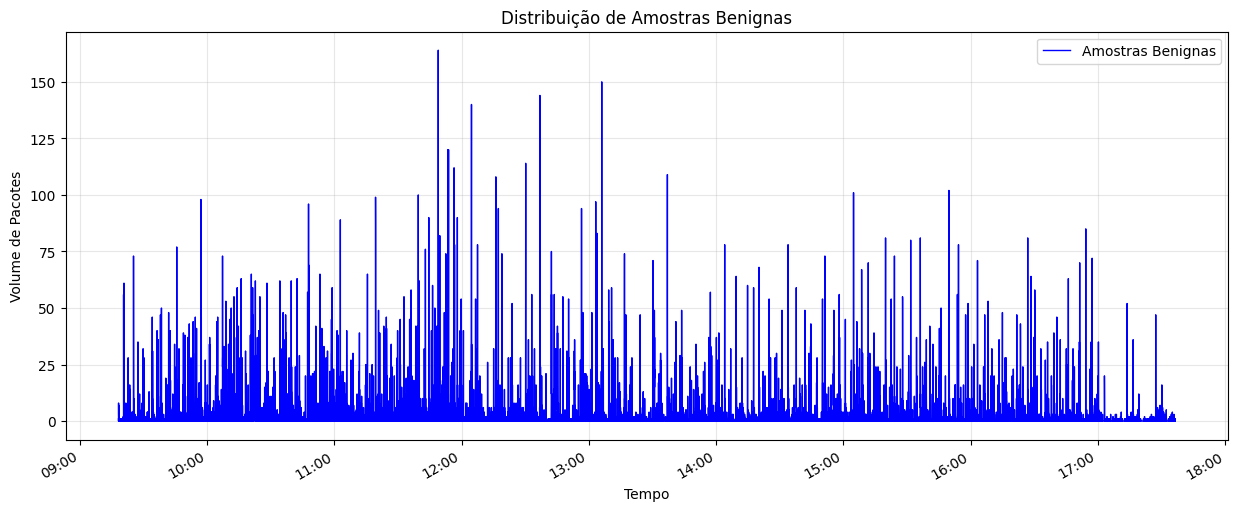


--- Analisando intervalos de silêncio (Lacunas) ---
-> Lacuna de 0 days 00:01:05.900139:
   Início do silêncio: 2018-11-03 17:06:04.943156
   Retorno da coleta:  2018-11-03 17:07:10.843295
   Índice de corte: 56377
------------------------------
-> Lacuna de 0 days 00:01:02.574077:
   Início do silêncio: 2018-11-03 17:11:38.903174
   Retorno da coleta:  2018-11-03 17:12:41.477251
   Índice de corte: 56406
------------------------------
-> Lacuna de 0 days 00:01:23.919238:
   Início do silêncio: 2018-11-03 17:20:09.421109
   Retorno da coleta:  2018-11-03 17:21:33.340347
   Índice de corte: 56632
------------------------------


In [7]:
# Configuração do caminho do arquivo
# file_path = 'datasets/CICDDoS2019/data/benign_0112.csv'
file_path = 'datasets/CICDDoS2019/data/benign_0311.csv'
df = pd.read_csv(file_path)

# Conversão e Ordenação 
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

print(f"Total de amostras: {len(df)}")
print(f"Início: {df['Timestamp'].min()}")
print(f"Fim:    {df['Timestamp'].max()}")

# Agrupamos 
# 'S' = segundos; 'T' = minutos; 'L/ms' = milissegundos; 'U/us' = microssegundos; 'N' = nanossegundos
df_plot = df.set_index('Timestamp').resample('S').size()

plt.figure(figsize=(15, 6))
plt.plot(df_plot.index, df_plot.values, linewidth=1, color='blue', label='Amostras Benignas')
plt.title('Distribuição de Amostras Benignas')
plt.xlabel('Tempo')
plt.ylabel('Volume de Pacotes')
plt.grid(True, alpha=0.3)
plt.legend()
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gcf().autofmt_xdate()
plt.show()

print("\n--- Analisando intervalos de silêncio (Lacunas) ---")

# Calcula a diferença de tempo entre o pacote atual e o anterior
# Certifique-se de que a coluna Timestamp já esteja no formato datetime
df['time_diff'] = df['Timestamp'].diff()

# Filtra onde a diferença é maior que o limite definido (60 segundos)
gaps = df[df['time_diff'] > pd.Timedelta(seconds=60)]

if not gaps.empty:    
    for index, row in gaps.iterrows():
        end_gap = row['Timestamp']
        duration = row['time_diff']
        start_gap = end_gap - duration
        
        print(f"-> Lacuna de {duration}:")
        print(f"   Início do silêncio: {start_gap}")
        print(f"   Retorno da coleta:  {end_gap}")
        print(f"   Índice de corte: {index}") 
        print("-" * 30)
else:
    print(f"Não foram encontradas lacunas temporais maiores que {60} segundos entre as amostras.")

### Cenários

#### Cenário Consistência

![DNS_DNS](datasets/CICDDoS2019/img/DNS_DNS.png)

In [ ]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0112.csv' 
caminho_ataque = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_DNS.csv'

# Índices das lacunas 
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques. Isso dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_full = pd.read_csv(caminho_ataque, nrows=24000) ### nrows é o número total de amostras de ataque que quero inserir (3 blocos de 8k)
df_attack_full.columns = df_attack_full.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_full.iloc[0:8000],      # Bloco 1
    df_attack_full.iloc[8000:16000],  # Bloco 2
    df_attack_full.iloc[16000:24000]  # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_DNS.csv
Total de amostras no arquivo final: 80863
Verificação: 56863 (Benignos) + 24000 (Ataques) = 80863


In [64]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
df = pd.read_csv(file_path, nrows=24000)

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Loop para analisar cada bloco de 8k
tamanho_bloco = 8000
total_blocos = len(df) // tamanho_bloco

for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim]
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        
        # Cálculo da duração
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")
        print("-" * 30)



>>> BLOCO 1 (Amostras 0 a 8000)
    Tempo Inicial: 2018-12-01 10:51:39.813448
    Tempo Final:   2018-12-01 10:57:06.839623
    Duração Total: 327.026175 segundos
------------------------------

>>> BLOCO 2 (Amostras 8000 a 16000)
    Tempo Inicial: 2018-12-01 10:57:06.870063
    Tempo Final:   2018-12-01 11:03:04.751877
    Duração Total: 357.881814 segundos
------------------------------

>>> BLOCO 3 (Amostras 16000 a 24000)
    Tempo Inicial: 2018-12-01 11:03:04.764335
    Tempo Final:   2018-12-01 11:06:05.647329
    Duração Total: 180.882994 segundos
------------------------------


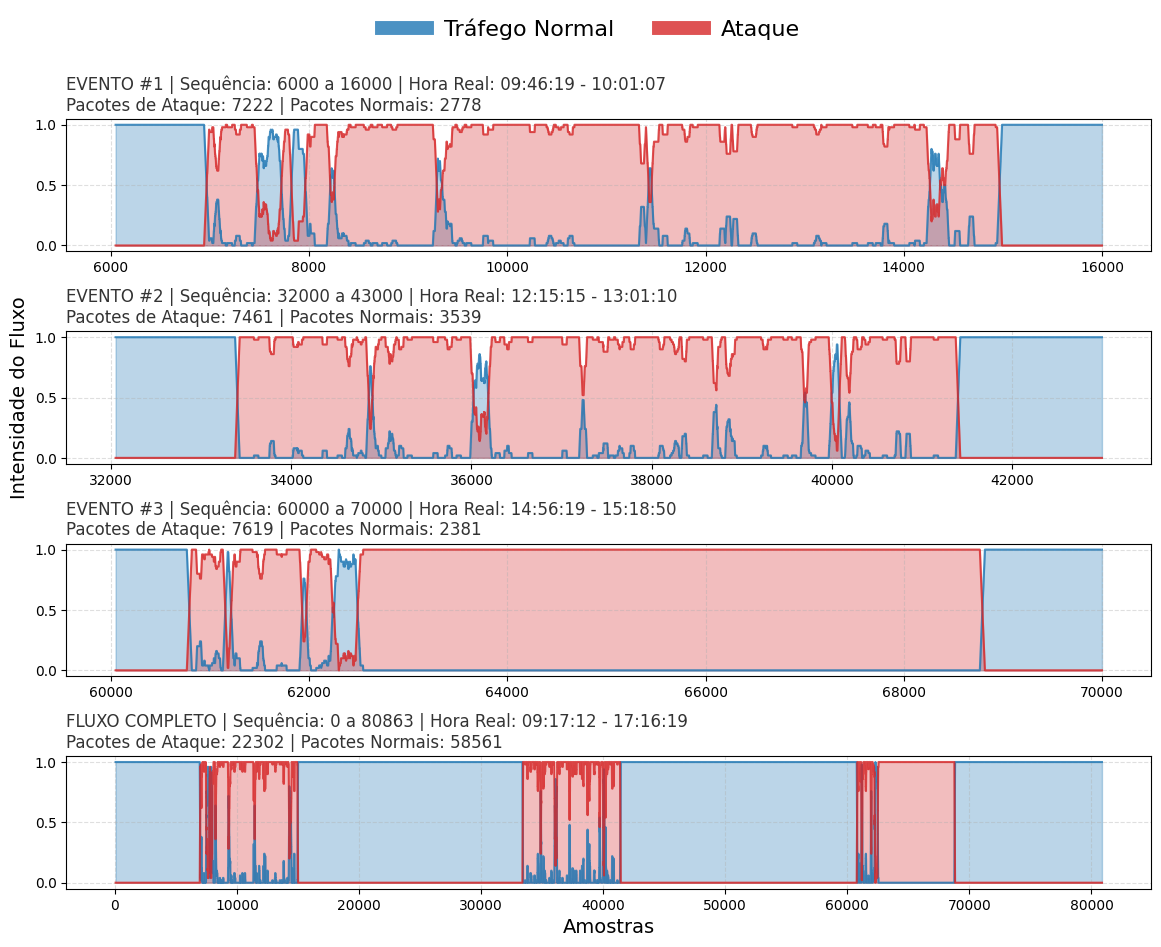

In [45]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_DNS.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = (df['Label'] == 'DrDoS_DNS').astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
                 ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenário Generalização 1

![DNS_LDAP](datasets/CICDDoS2019/img/DNS_LDAP.png)

In [ ]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0112.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDoS_LDAP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_DNS_LDAP.csv'

# Índices das lacunas 
indices_lacunas = [6942, 25376]

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque 
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=8000)
df_attack_1.columns = df_attack_1.columns.str.strip()

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=110000) 
df_attack_2.columns = df_attack_2.columns.str.strip() # Remover espaços extras nas colunas


# Dividir blocos
blocos_ataque = [
    df_attack_1,        # Bloco 1
    df_attack_2,        # Bloco 2
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:],    # Benigno (25376 -> 44767)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_DNS_LDAP.csv
Total de amostras no arquivo final: 174863



>>> BLOCO 1 (Amostras 0 a 110000)
    Tempo Inicial: 2018-12-01 11:22:40.254769
    Tempo Final:   2018-12-01 11:23:09.759926
    Duração Total: 29.505157 segundos


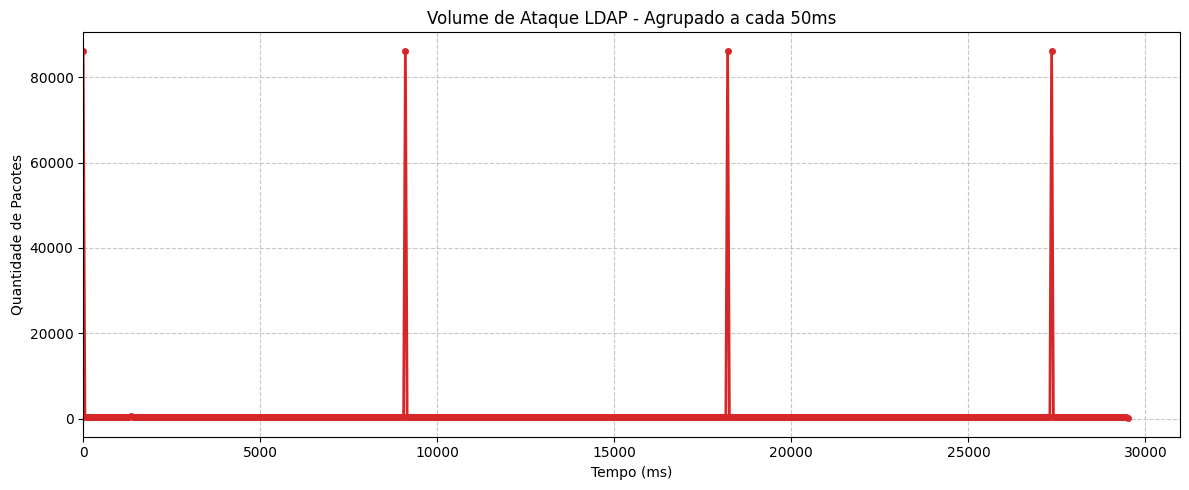

In [ ]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_LDAP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 1), nrows=110000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 110000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")
        
        # Calcular o Tempo Relativo em milissegundos (ms) a partir do zero
        bloco['Relative_Time_ms'] = (bloco['Timestamp'] - t_inicio).dt.total_seconds() * 1000
        
        # Calcular o Total de Pacotes por fluxo (Fwd + Bwd)
        bloco['Total_Packets'] = bloco['Total Fwd Packets'] + bloco['Total Backward Packets']
        
        # Agrupar em 'Bins' de tempo para ver o volume
        janela_ms = 50 
        bloco['Time_Bin'] = (bloco['Relative_Time_ms'] // janela_ms) * janela_ms
        
        # Soma a quantidade de pacotes em cada janela de tempo
        volume_por_tempo = bloco.groupby('Time_Bin')['Total_Packets'].sum()
        
        # --- PLOTAGEM ---
        plt.figure(figsize=(12, 5))
        plt.plot(volume_por_tempo.index, volume_por_tempo.values, 
                 marker='o', linestyle='-', color='tab:red', linewidth=2, markersize=4)
        
        plt.title(f'Volume de Ataque LDAP - Agrupado a cada {janela_ms}ms')
        plt.xlabel('Tempo (ms)')
        plt.ylabel('Quantidade de Pacotes')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.xlim(left=0)
        plt.tight_layout()
        plt.show()

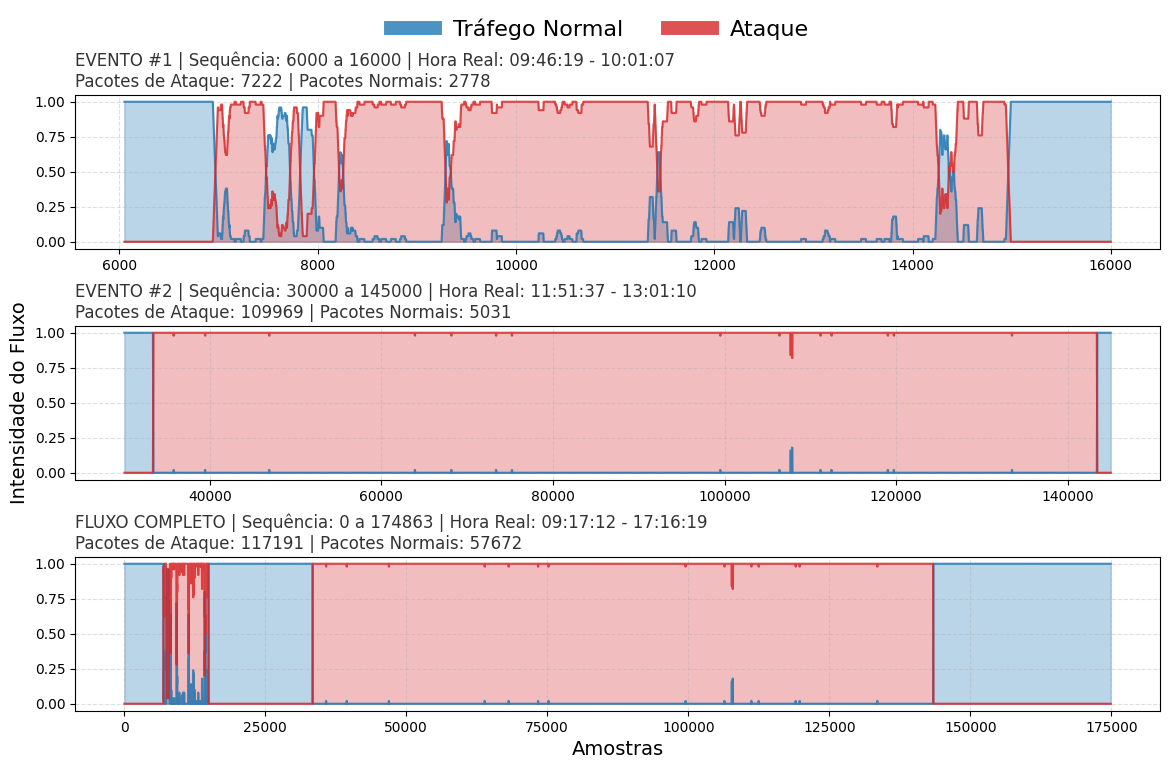

In [ ]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_DNS_LDAP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_LDAP', 'DrDoS_DNS']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
# Esse ´o zoom #######
eventos = [
    (6000, 16000),   # Evento 1
    (30000, 145000),  # Evento 2
    (0, len(df))   # Evento 3 (Fluxo Completo)
]

# Configuração do Gráfico
fig, axes = plt.subplots(3, 1, figsize=(14, 8))
plt.subplots_adjust(hspace=0.5, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 2:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
                 ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenário Generalização 2

![Portmap_NetBIOS](datasets/CICDDoS2019/img/Portmap_NetBIOS.png)

In [22]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/03-11/Portmap.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/03-11/NetBIOS.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_Portmap_NetBIOS.csv'

# Índices das lacunas 
indices_lacunas = [15000, 45000]

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque 
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=15000)
df_attack_1.columns = df_attack_1.columns.str.strip()

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=15000) 
df_attack_2.columns = df_attack_2.columns.str.strip()


# Dividir em 3 blocos de 8.000
blocos_ataque = [
    df_attack_1,        # Bloco 1
    df_attack_2,        # Bloco 2
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        
    blocos_ataque[0],             
    df_benign.iloc[idx1:idx2],    
    blocos_ataque[1],             
    df_benign.iloc[idx2:],    
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_Portmap_NetBIOS.csv
Total de amostras no arquivo final: 86965


In [13]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/03-11/Portmap.csv'
df = pd.read_csv(file_path, skiprows=range(1, 15000), nrows=15000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 15000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 15000)
    Tempo Inicial: 2018-11-03 10:01:26.992411
    Tempo Final:   2018-11-03 10:01:28.880568
    Duração Total: 1.888157 segundos


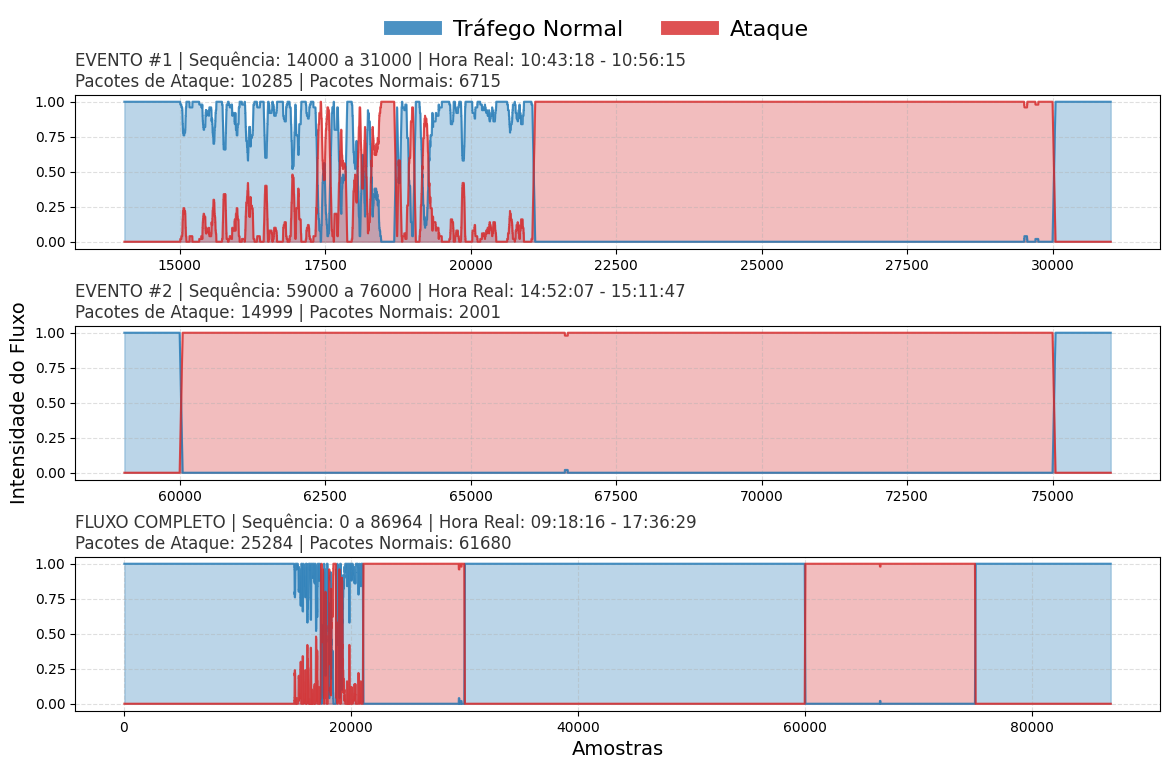

In [41]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_Portmap_NetBIOS.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['Portmap', 'NetBIOS']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (14000, 31000),   # Evento 1
    (59000, 76000),  # Evento 2
    (0, len(df)-1)   # Evento 3
]

# Configuração do Gráfico
fig, axes = plt.subplots(3, 1, figsize=(14, 8))
plt.subplots_adjust(hspace=0.5, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 2:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
              f"Hora Real: {hora_ini} - {hora_fim}\n"
              f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0), 
                 ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenários Heterogeneidade

- Ataques: Syn (x) e DrDoS NTP (Y)
    - Ataques com características muito diferentes.
- Cenários:
    - Cenário A: x -> y -> x
    - Cenário B: y -> x -> y
- Objetivo: Testar a capacidade de adaptação e mémoria dos modelos em relação a ataques diferentes.
    - Depois de ver x é mais fácil identificar y e vice-versa:
    - O modelo esquece x após passar pelo y? E o contrário?

##### Cenário A

In [5]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/Syn.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_NTP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_Syn_NTP.csv'

# Índices das lacunas 
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_1.iloc[8000:16000]   # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_Syn_NTP.csv
Total de amostras no arquivo final: 80965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [6]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_NTP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 10:36:06.177617
    Tempo Final:   2018-12-01 10:36:12.167951
    Duração Total: 5.990334 segundos


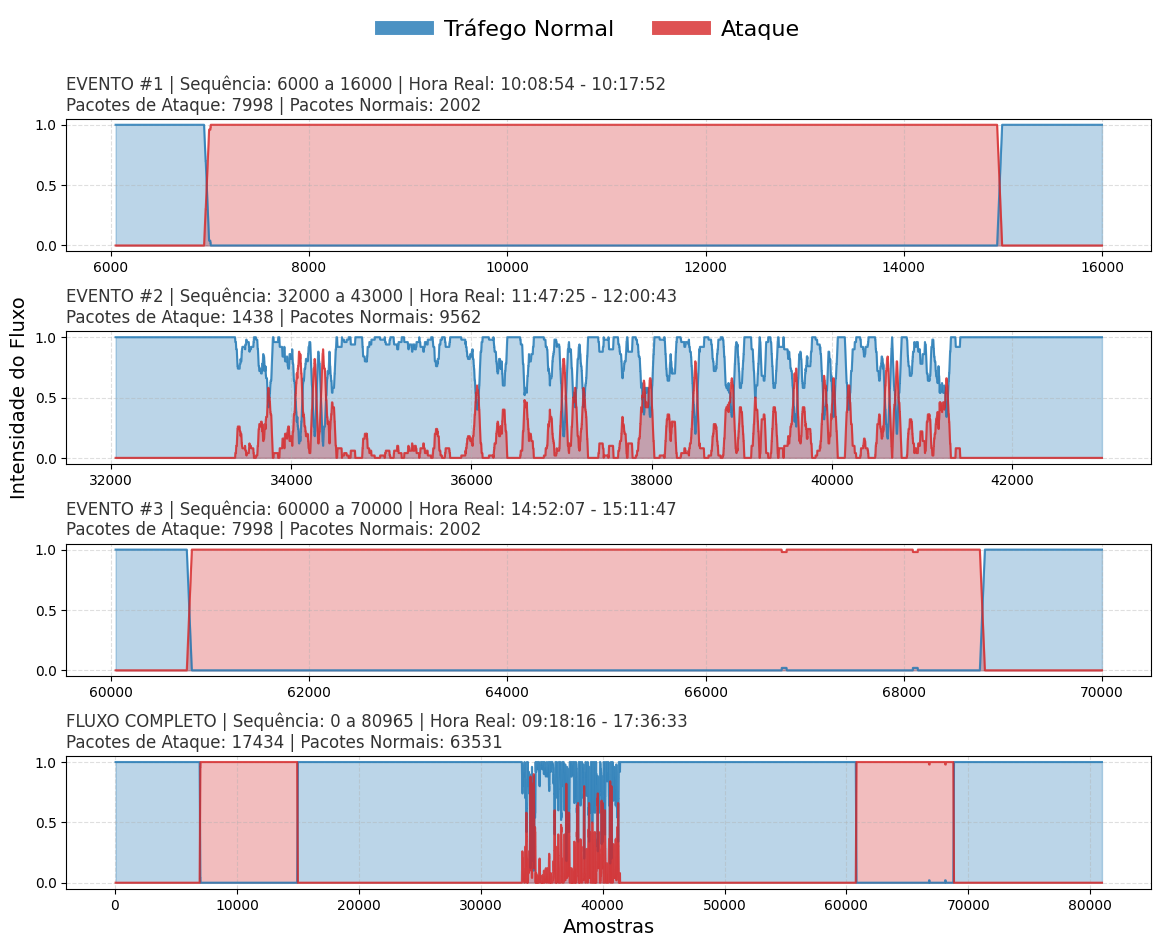

In [7]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_Syn_NTP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['Syn', 'DrDoS_NTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

##### Cenário B

In [8]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/Syn.csv'
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_NTP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_NTP_Syn.csv'

# Índices das lacunas
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_1.iloc[8000:16000]   # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_NTP_Syn.csv
Total de amostras no arquivo final: 80965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [19]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/Syn.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 13:30:32.378151
    Tempo Final:   2018-12-01 13:30:34.023031
    Duração Total: 1.644880 segundos


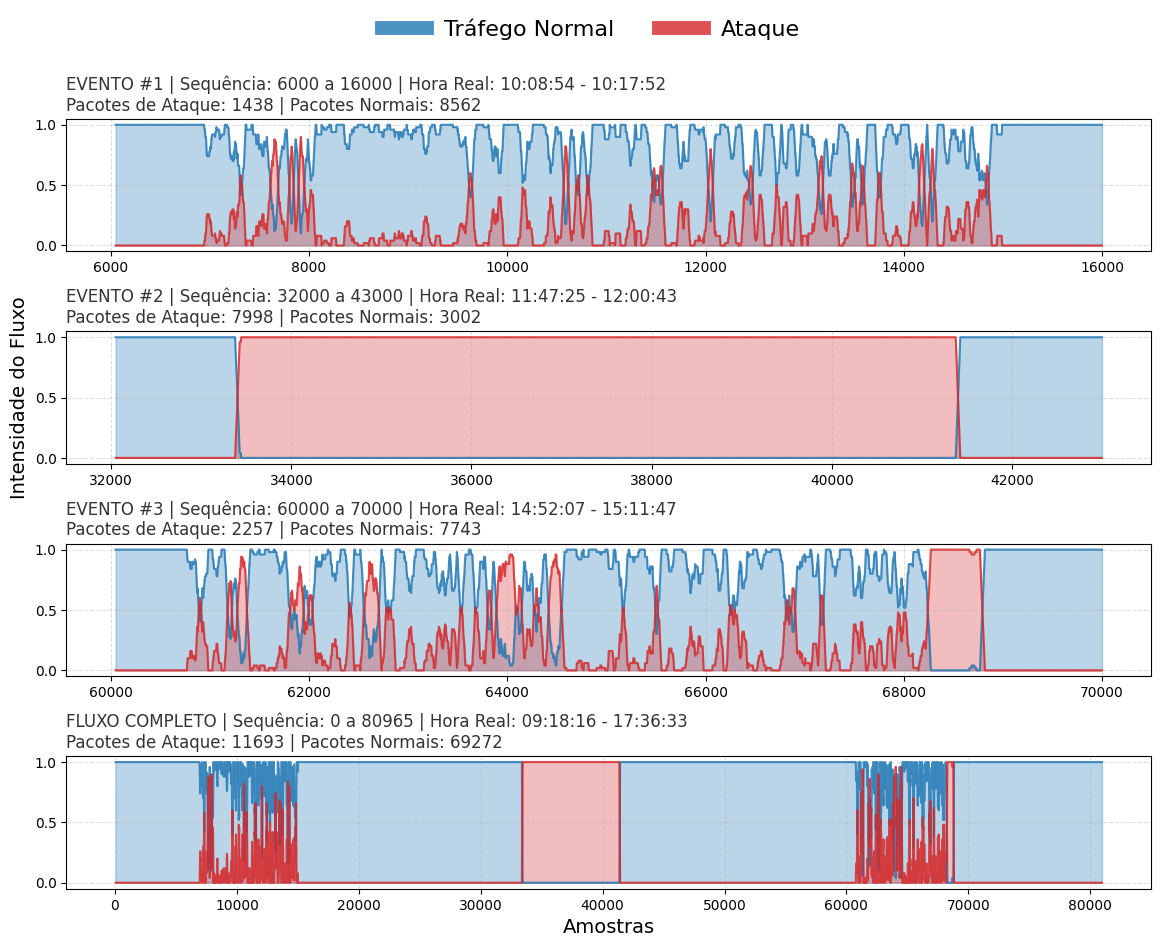

In [17]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_NTP_Syn.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['Syn', 'DrDoS_NTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenário Generalização 3

- Ataques: SSDP (A) e UDP (B)
    - Ataques com características muito semelhantes.
- Cenários:
    - Cenário D: A -> B -> A
    - Cenário E: A -> A -> B
    - Cenário F: B -> A -> B
- Objetivo: Testar a capacidade de adaptação dos modelos quando encontram sequências de ataques muito parecidos; verificar se encontrar A A antes de B ajuda na adaptação.

##### Cenário D

In [11]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_SSDP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_SSDP_UDP.csv'

# Índices das lacunas
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_1.iloc[8000:16000]   # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_SSDP_UDP.csv
Total de amostras no arquivo final: 80965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [15]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_SSDP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 12:23:15.580867
    Tempo Final:   2018-12-01 12:25:51.017011
    Duração Total: 155.436144 segundos


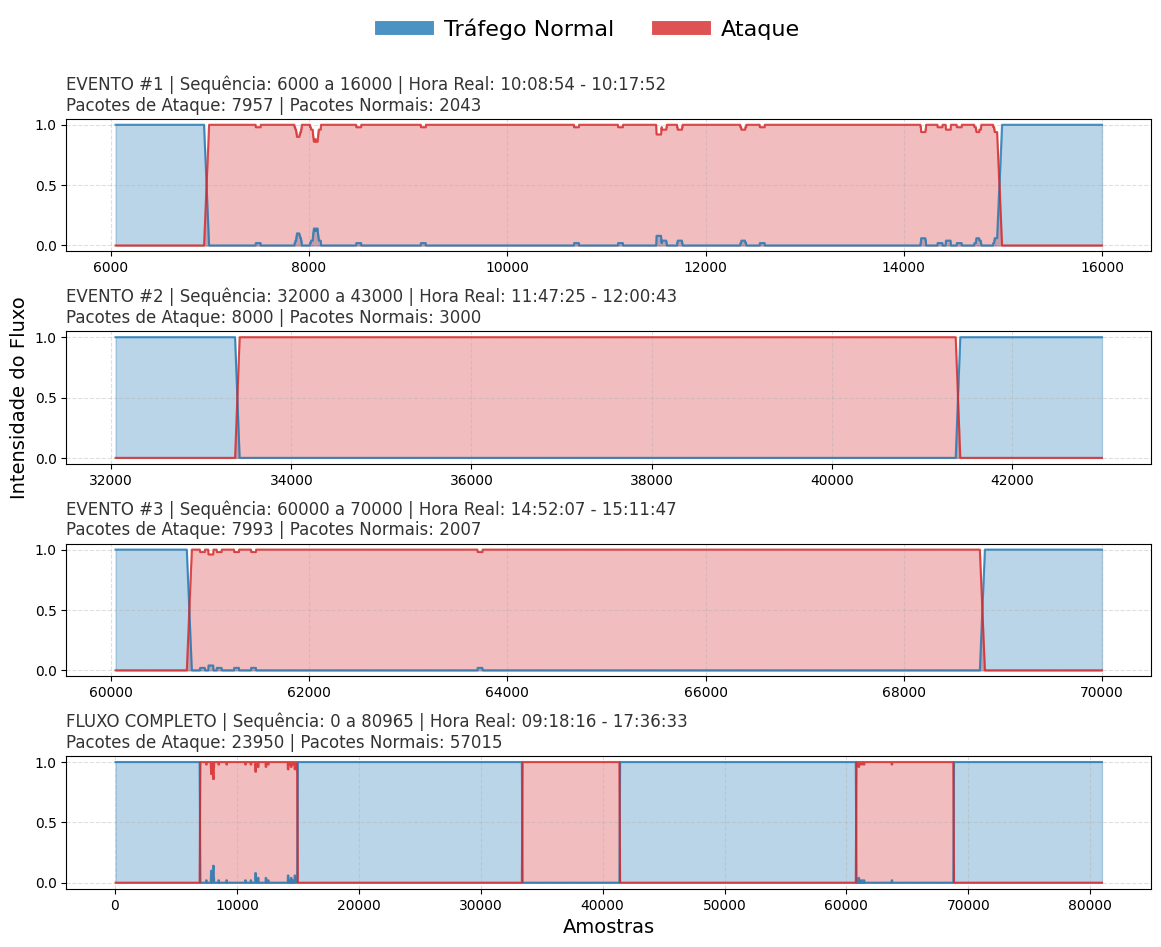

In [16]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_SSDP_UDP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_SSDP', 'DrDoS_UDP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

##### Cenário E

In [23]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_SSDP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_SSDP_SSDP_UDP.csv'

# Índices das lacunas 
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_1.iloc[8000:16000],  # Bloco 2
    df_attack_2.iloc[0:8000]       # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_SSDP_SSDP_UDP.csv
Total de amostras no arquivo final: 80965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [24]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_SSDP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 12:23:15.580867
    Tempo Final:   2018-12-01 12:25:51.017011
    Duração Total: 155.436144 segundos


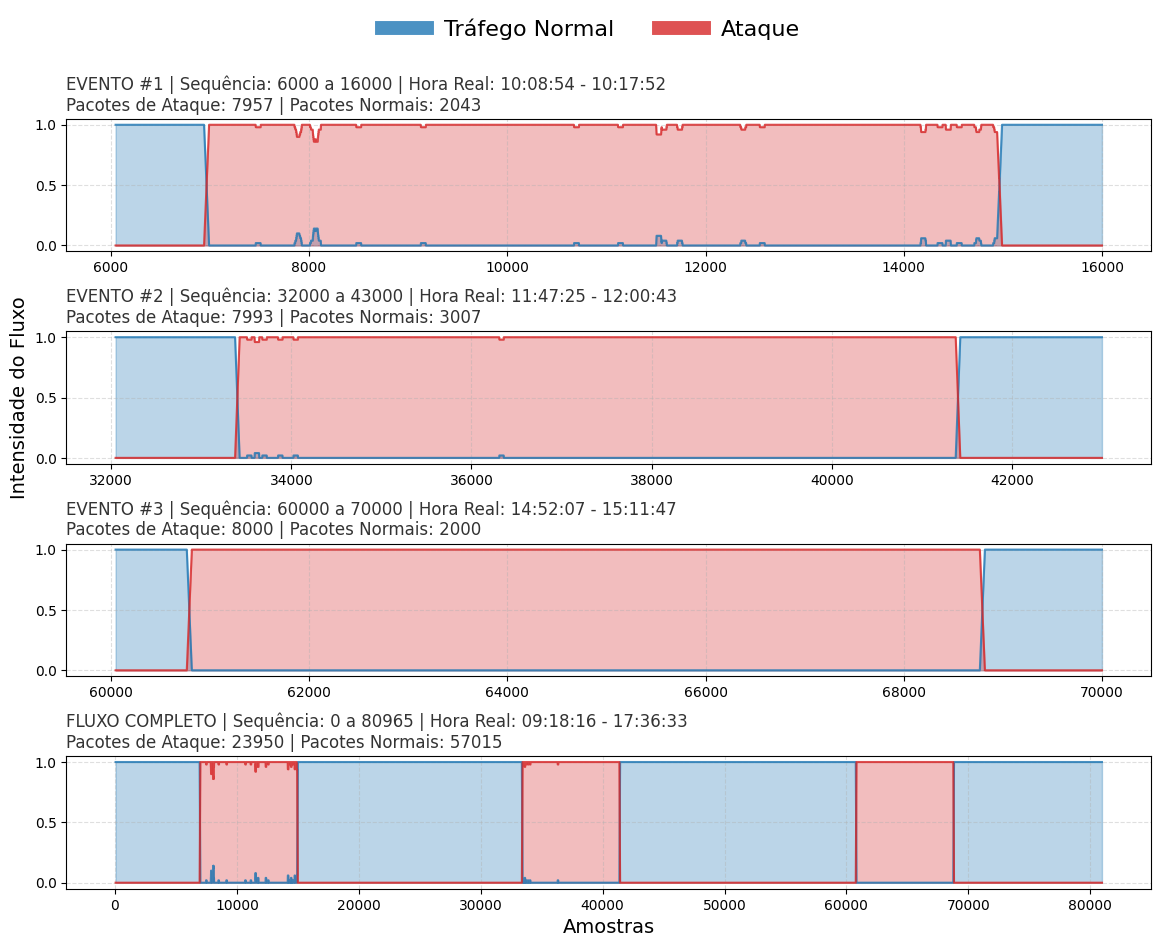

In [25]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_SSDP_SSDP_UDP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_SSDP', 'DrDoS_UDP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

##### Cenário F

In [20]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv'
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_SSDP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_UDP_SSDP.csv'

# Índices das lacunas 
indices_lacunas = [6942, 25376, 44768] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_1.iloc[8000:16000]   # Bloco 3
]

idx1 = indices_lacunas[0] # 6942
idx2 = indices_lacunas[1] # 25376
idx3 = indices_lacunas[2] # 44768

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 6941)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (6942 -> 25375)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (25376 -> 44767)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:]         # Benigno (44768 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_UDP_SSDP.csv
Total de amostras no arquivo final: 80965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [21]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_UDP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 12:36:59.893494
    Tempo Final:   2018-12-01 12:37:02.744641
    Duração Total: 2.851147 segundos


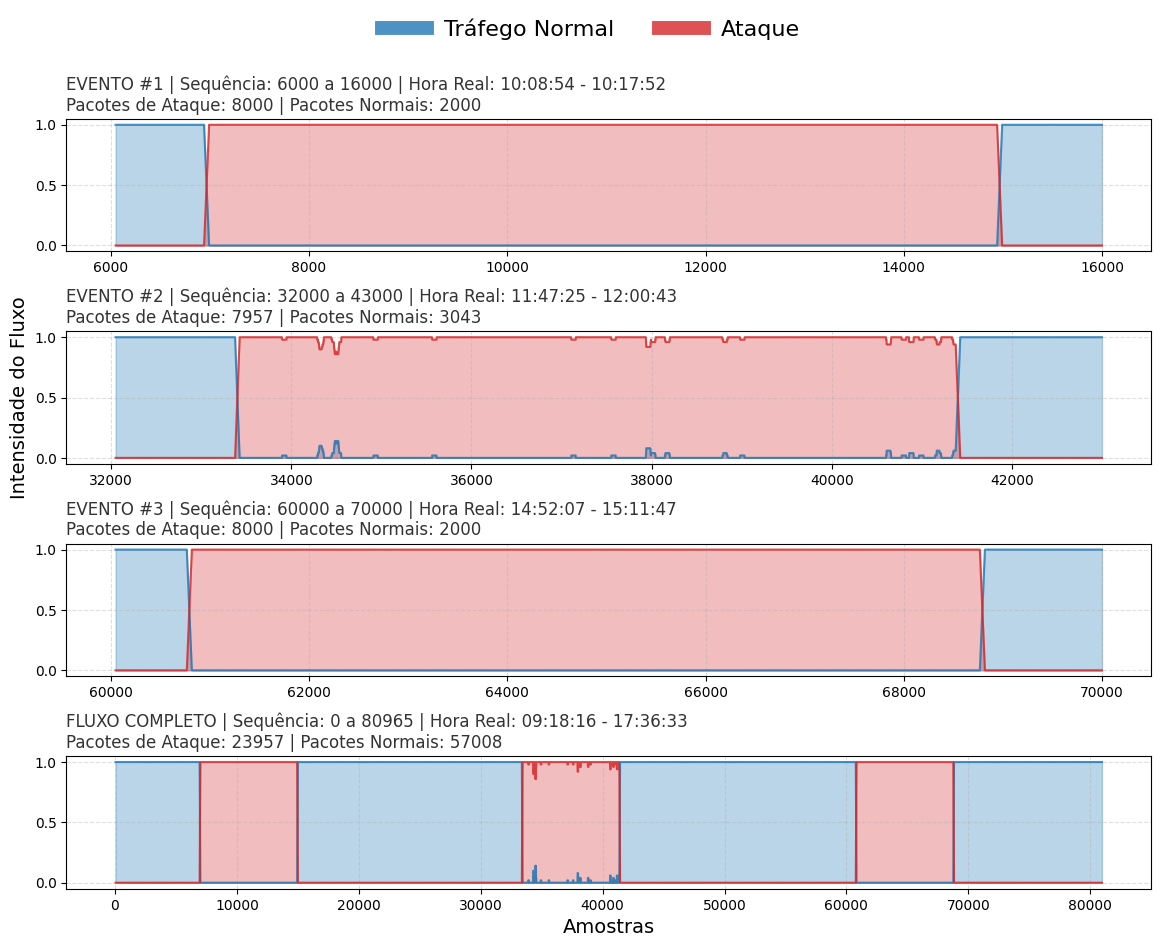

In [22]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_UDP_SSDP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_UDP', 'DrDoS_SSDP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (6000, 16000),   # Evento 1
    (32000, 43000),  # Evento 2
    (60000, 70000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenário Generalização 4

- Ataques: SSDP (A); UDP (B); TFTP (C).
    - A e B são muito parecidos; C está no mesmo grupo de similaridade mas difere um pouco mais.
- Cenários:
    - Cenário G: A -> B -> C -> A.
    - Cenário H: C -> B -> A -> C.
    - Cenário  I: B -> C -> A -> B.
- Objetivo: Analizar como os modelos respondem diante de três ataques semelhantes, mas agora com um deles não tão parecido; ver como o C influencia quando a ocorrencia é entre A e B.


##### Cenário G

In [54]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_SSDP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_ataque_3 = 'datasets/CICDDoS2019/01-12/TFTP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_SSDP_UDP_TFTP.csv'

# Índices das lacunas 
indices_lacunas = [11393, 22786, 34179, 45572] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

df_attack_3 = pd.read_csv(caminho_ataque_3, skiprows=range(1, 1), nrows=8000)
df_attack_3.columns = df_attack_3.columns.str.strip() ### remove os espaços das

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 4 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_3.iloc[0:8000],      # Bloco 3
    df_attack_1.iloc[8000:16000]   # Bloco 4
]

idx1 = indices_lacunas[0] # 11393
idx2 = indices_lacunas[1] # 22786
idx3 = indices_lacunas[2] # 34179
idx4 = indices_lacunas[3] # 45572

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 11392)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (11393 -> 22785)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (22786 -> 34178)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:idx4],    # Benigno (34179 -> 45571)
    blocos_ataque[3],             # Ataque 4 (8k)
    df_benign.iloc[idx4:]         # Benigno (45572 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 32000 (Ataques) = {len(df_benign) + 32000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_SSDP_UDP_TFTP.csv
Total de amostras no arquivo final: 88965
Verificação: 56965 (Benignos) + 32000 (Ataques) = 88965


In [55]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_SSDP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 12:23:15.580867
    Tempo Final:   2018-12-01 12:25:51.017011
    Duração Total: 155.436144 segundos


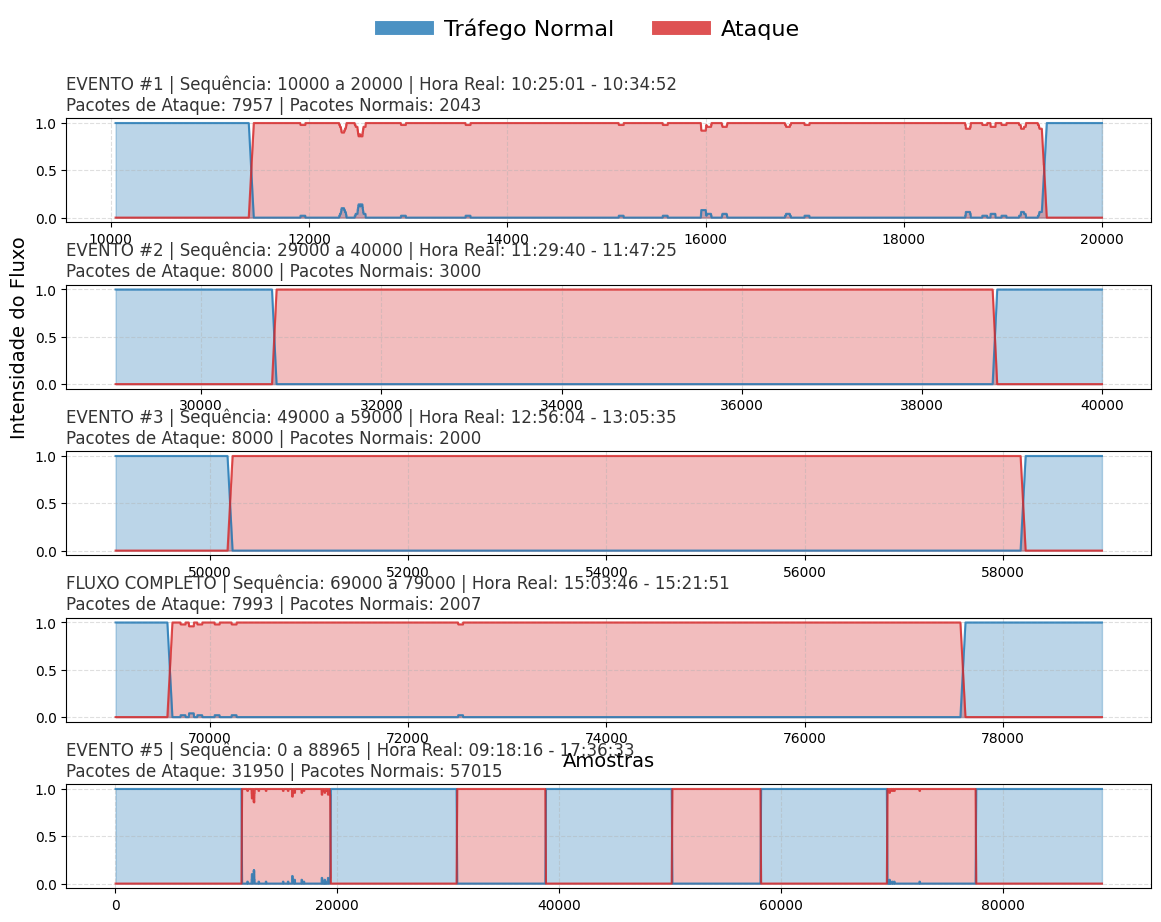

In [56]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_SSDP_UDP_TFTP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_SSDP', 'DrDoS_UDP', 'TFTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (10000, 20000),   # Evento 1
    (29000, 40000),   # Evento 2
    (49000, 59000),   # Evento 3
    (69000, 79000),   # Evento 4
    (0, len(df))      # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(5, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

##### Cenário H

In [51]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/TFTP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_ataque_3 = 'datasets/CICDDoS2019/01-12/DrDos_SSDP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_TFTP_UDP_SSDP.csv'

# Índices das lacunas 
indices_lacunas = [11393, 22786, 34179, 45572] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

df_attack_3 = pd.read_csv(caminho_ataque_3, skiprows=range(1, 1), nrows=8000)
df_attack_3.columns = df_attack_3.columns.str.strip() ### remove os espaços das

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 4 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_3.iloc[0:8000],      # Bloco 3
    df_attack_1.iloc[8000:16000]   # Bloco 4
]

idx1 = indices_lacunas[0] # 11393
idx2 = indices_lacunas[1] # 22786
idx3 = indices_lacunas[2] # 34179
idx4 = indices_lacunas[3] # 45572

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 11392)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (11393 -> 22785)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (22786 -> 34178)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:idx4],    # Benigno (34179 -> 45571)
    blocos_ataque[3],             # Ataque 4 (8k)
    df_benign.iloc[idx4:]         # Benigno (45572 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 32000 (Ataques) = {len(df_benign) + 32000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_TFTP_UDP_SSDP.csv
Total de amostras no arquivo final: 88965
Verificação: 56965 (Benignos) + 32000 (Ataques) = 88965


In [52]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/TFTP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 13:34:28.958286
    Tempo Final:   2018-12-01 13:34:30.517756
    Duração Total: 1.559470 segundos


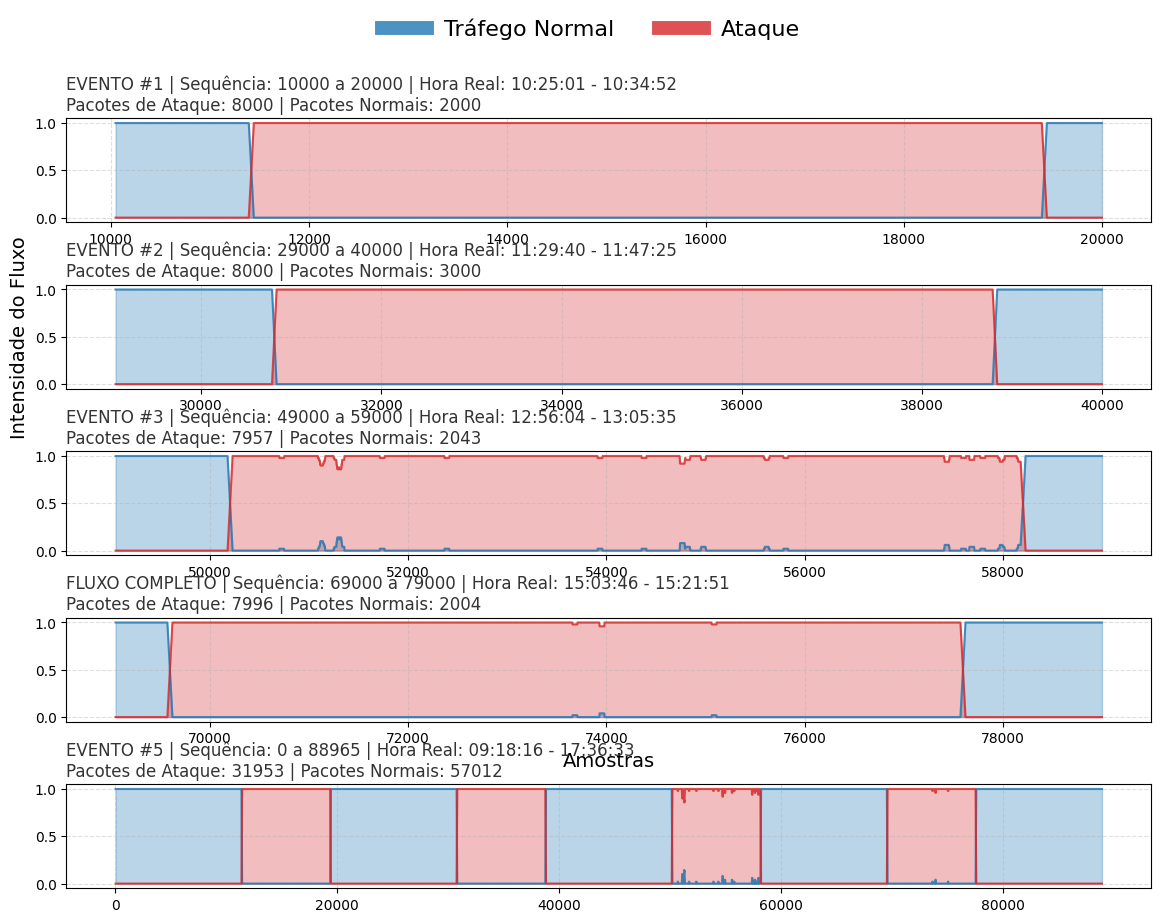

In [53]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_TFTP_UDP_SSDP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_SSDP', 'DrDoS_UDP', 'TFTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (10000, 20000),   # Evento 1
    (29000, 40000),   # Evento 2
    (49000, 59000),   # Evento 3
    (69000, 79000),   # Evento 4
    (0, len(df))      # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(5, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

##### Cenário I

In [57]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDos_UDP.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/TFTP.csv'
caminho_ataque_3 = 'datasets/CICDDoS2019/01-12/DrDoS_SSDP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Benign_UDP_TFTP_SSDP.csv'

# Índices das lacunas 
indices_lacunas = [11393, 22786, 34179, 45572] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

df_attack_3 = pd.read_csv(caminho_ataque_3, skiprows=range(1, 1), nrows=8000)
df_attack_3.columns = df_attack_3.columns.str.strip() ### remove os espaços das

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 4 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_3.iloc[0:8000],      # Bloco 3
    df_attack_1.iloc[8000:16000]   # Bloco 4
]

idx1 = indices_lacunas[0] # 11393
idx2 = indices_lacunas[1] # 22786
idx3 = indices_lacunas[2] # 34179
idx4 = indices_lacunas[3] # 45572

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 11392)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (11393 -> 22785)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (22786 -> 34178)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:idx4],    # Benigno (34179 -> 45571)
    blocos_ataque[3],             # Ataque 4 (8k)
    df_benign.iloc[idx4:]         # Benigno (45572 -> Final)
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 32000 (Ataques) = {len(df_benign) + 32000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Benign_UDP_TFTP_SSDP.csv
Total de amostras no arquivo final: 88965
Verificação: 56965 (Benignos) + 32000 (Ataques) = 88965


In [58]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_UDP.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 12:36:59.893494
    Tempo Final:   2018-12-01 12:37:02.744641
    Duração Total: 2.851147 segundos


In [59]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Benign_UDP_TFTP_SSDP.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_SSDP', 'DrDoS_UDP', 'TFTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (10000, 20000),   # Evento 1
    (29000, 40000),   # Evento 2
    (49000, 59000),   # Evento 3
    (69000, 79000),   # Evento 4
    (0, len(df))      # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(5, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

#### Cenário Heterogeneidade 2

- Ataques: Múltiplos ataques de grupos de similaridade distinto.
    - Sequência de 6 ataques e uma recorrência do primeiro ataque no fim.
- Objetivo: Analizar como os modelos respondem a muitas mudanças de conceito, e, após essas mudanças, a recorrência.

##### Cenário J

In [63]:
caminho_benigno = 'datasets/CICDDoS2019/data/benign_0311.csv' 
caminho_ataque_1 = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
caminho_ataque_2 = 'datasets/CICDDoS2019/01-12/DrDoS_SNMP.csv'
caminho_ataque_3 = 'datasets/CICDDoS2019/01-12/Syn.csv'
caminho_ataque_4 = 'datasets/CICDDoS2019/01-12/DrDoS_NetBIOS.csv'
caminho_ataque_5 = 'datasets/CICDDoS2019/01-12/DrDoS_MSSQL.csv'
caminho_ataque_6 = 'datasets/CICDDoS2019/01-12/TFTP.csv'
caminho_saida = 'datasets/CICDDoS2019/data/Multiplos_Ataques.csv'

# Índices das lacunas 
indices_lacunas = [8137, 16274, 24411, 32548, 40685, 48822, 56959] ### Aqui são os índices onde eu vou inserir os blocos de ataques dentro do fluxo benigno.

# Criar diretório de saída se não existir
os.makedirs(os.path.dirname(caminho_saida), exist_ok=True)

# Carregar Amostras Benignas
df_benign = pd.read_csv(caminho_benigno)

# Carregar e Preparar Amostras de Ataque
df_attack_1 = pd.read_csv(caminho_ataque_1, nrows=16000) ### nrows é o número total de amostras de ataque que quero inserir (2 blocos de 8k)
df_attack_1.columns = df_attack_1.columns.str.strip() ### remove os espaços das colunas

df_attack_2 = pd.read_csv(caminho_ataque_2, skiprows=range(1, 1), nrows=8000)
df_attack_2.columns = df_attack_2.columns.str.strip() ### remove os espaços das colunas

df_attack_3 = pd.read_csv(caminho_ataque_3, skiprows=range(1, 1), nrows=8000)
df_attack_3.columns = df_attack_3.columns.str.strip() ### remove os espaços das colunas

df_attack_4 = pd.read_csv(caminho_ataque_4, skiprows=range(1, 1), nrows=8000)
df_attack_4.columns = df_attack_4.columns.str.strip() ### remove os espaços das colunas

df_attack_5 = pd.read_csv(caminho_ataque_5, skiprows=range(1, 1), nrows=8000)
df_attack_5.columns = df_attack_5.columns.str.strip() ### remove os espaços das colunas

df_attack_6 = pd.read_csv(caminho_ataque_6, skiprows=range(1, 1), nrows=8000)
df_attack_6.columns = df_attack_6.columns.str.strip() ### remove os espaços das colunas

# Dividir em 3 blocos de 8.000
### Aqui ele divide o DataFrame de ataques em 3 partes iguais, cada uma com 8.000 amostras, para serem inseridas nos pontos definidos pelas lacunas no fluxo benigno.
blocos_ataque = [
    df_attack_1.iloc[0:8000],      # Bloco 1
    df_attack_2.iloc[0:8000],      # Bloco 2
    df_attack_3.iloc[0:8000],      # Bloco 3
    df_attack_4.iloc[0:8000],      # Bloco 4
    df_attack_5.iloc[0:8000],      # Bloco 5
    df_attack_6.iloc[0:8000],      # Bloco 6
    df_attack_1.iloc[8000:16000]   # Bloco 7
]

idx1 = indices_lacunas[0] # 8137
idx2 = indices_lacunas[1] # 16274
idx3 = indices_lacunas[2] # 24411
idx4 = indices_lacunas[3] # 32548
idx5 = indices_lacunas[4] # 40685
idx6 = indices_lacunas[5] # 48822
idx7 = indices_lacunas[6] # 56959

# Construir o fluxo final intercalando benignos e ataques
fluxo_final = [
    df_benign.iloc[:idx1],        # Benigno (Início -> 8137)
    blocos_ataque[0],             # Ataque 1 (8k)
    df_benign.iloc[idx1:idx2],    # Benigno (8138 -> 16274)
    blocos_ataque[1],             # Ataque 2 (8k)
    df_benign.iloc[idx2:idx3],    # Benigno (16275 -> 24411)
    blocos_ataque[2],             # Ataque 3 (8k)
    df_benign.iloc[idx3:idx4],    # Benigno (24412 -> 32548)
    blocos_ataque[3],             # Ataque 4 (8k)
    df_benign.iloc[idx4:idx5],    # Benigno (32549 -> 40685)
    blocos_ataque[4],             # Ataque 5 (8k)
    df_benign.iloc[idx5:idx6],    # Benigno (40686 -> 48822)
    blocos_ataque[5],             # Ataque 6 (8k)
    df_benign.iloc[idx6:idx7],    # Benigno (48823 -> 56959)
    blocos_ataque[6],             # Ataque 7 (8k)
    df_benign.iloc[idx7:]         # Benigno (56960 -> Final)
    
    
]

# Concatenar tudo em um único DataFrame
df_final = pd.concat(fluxo_final, ignore_index=True)

# --- SALVAR ARQUIVO ---
print("--- Salvando Arquivo Final ---")
df_final.to_csv(caminho_saida, index=False)

print(f"Sucesso! Arquivo salvo em: {caminho_saida}")
print(f"Total de amostras no arquivo final: {len(df_final)}")
print(f"Verificação: {len(df_benign)} (Benignos) + 24000 (Ataques) = {len(df_benign) + 24000}")

--- Salvando Arquivo Final ---
Sucesso! Arquivo salvo em: datasets/CICDDoS2019/data/Multiplos_Ataques.csv
Total de amostras no arquivo final: 112965
Verificação: 56965 (Benignos) + 24000 (Ataques) = 80965


In [ ]:
# Configuração e Carregamento
file_path = 'datasets/CICDDoS2019/01-12/DrDoS_DNS.csv'
df = pd.read_csv(file_path, skiprows=range(1, 16000), nrows=16000) 

# Limpeza e Conversão
df.columns = df.columns.str.strip()
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df = df.dropna(subset=['Timestamp'])
df = df.sort_values('Timestamp')

# Configuração dos Blocos
tamanho_bloco = 16000
total_blocos = len(df) // tamanho_bloco

# Loop para analisar cada bloco
for i in range(total_blocos):
    idx_inicio = i * tamanho_bloco
    idx_fim = (i + 1) * tamanho_bloco
    
    # Pega o pedaço do dataframe 
    bloco = df.iloc[idx_inicio:idx_fim].copy() 
    
    if not bloco.empty:
        t_inicio = bloco['Timestamp'].iloc[0]
        t_fim = bloco['Timestamp'].iloc[-1]
        duracao = (t_fim - t_inicio).total_seconds()
        
        print(f"\n>>> BLOCO {i+1} (Amostras {idx_inicio} a {idx_fim})")
        print(f"    Tempo Inicial: {t_inicio}")
        print(f"    Tempo Final:   {t_fim}")
        print(f"    Duração Total: {duracao:.6f} segundos")


>>> BLOCO 1 (Amostras 0 a 16000)
    Tempo Inicial: 2018-12-01 10:36:06.177617
    Tempo Final:   2018-12-01 10:36:12.167951
    Duração Total: 5.990334 segundos


In [65]:
# Carregar e Preparar Dados
df = pd.read_csv('datasets/CICDDoS2019/data/Multiplos_Ataques.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Flags numéricas (0 ou 1) para calcular a densidade
df['flag_ataque'] = df['Label'].isin(['DrDoS_DNS', 'DrDoS_SNMP', 'DrDoS_NetBIOS', 'Syn', 'DrDoS_MSSQL', 'TFTP']).astype(int)
df['flag_benigno'] = (df['Label'] == 'BENIGN').astype(int)

# Definição Manual dos Eventos (Cortes onde ocorrem os ataques)
eventos = [
    (7000, 17000),   # Evento 1
    (23000, 33000),  # Evento 2
    (39000, 49000),   # Evento 3
    (0, len(df))     # Evento Completo
]

# Configuração do Gráfico
fig, axes = plt.subplots(4, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.6, top=0.88) # Espaço extra no topo para a legenda e entre gráficos
cor_benigno = '#1f77b4' 
cor_ataque = '#d62728'  

# Loop para gerar os 3 gráficos
for i, (inicio, fim) in enumerate(eventos):
    ax = axes[i]
    
    # Recorte dos dados
    fatia = df.iloc[inicio:fim].copy()
    
    # Média Móvel
    suave_ataque = fatia['flag_ataque'].rolling(window=50).mean()
    suave_benigno = fatia['flag_benigno'].rolling(window=50).mean()
    
    # --- PLOTAGEM ---
    # Área preenchida com transparência (alpha=0.3)
    ax.fill_between(fatia.index, suave_benigno, color=cor_benigno, alpha=0.3)
    ax.fill_between(fatia.index, suave_ataque, color=cor_ataque, alpha=0.3)
    
    # Linhas de contorno um pouco mais fortes (alpha=0.8) para definição
    ax.plot(fatia.index, suave_benigno, color=cor_benigno, alpha=0.8, linewidth=1.5, label='Tráfego Normal')
    ax.plot(fatia.index, suave_ataque, color=cor_ataque, alpha=0.8, linewidth=1.5, label='Ataque')
    
    # --- DADOS PARA O TÍTULO ---
    hora_ini = fatia['Timestamp'].iloc[0].strftime('%H:%M:%S')
    hora_fim = fatia['Timestamp'].iloc[-1].strftime('%H:%M:%S')
    total_ataque = fatia['flag_ataque'].sum()
    total_normal = fatia['flag_benigno'].sum()
    
    # Título Personalizado
    titulo = (f"\nEVENTO #{i+1} | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
    
    ax.set_title(titulo, loc='left', fontsize=12, color='#333')
    ax.grid(True, linestyle='--', alpha=0.4)

    if i == 1:
        ax.set_ylabel("Intensidade do Fluxo", fontsize=14)

    # Eixo X apenas no último gráfico
    if i == 3:
        ax.set_xlabel("Amostras", fontsize=14)

        titulo = (f"\nFLUXO COMPLETO | Sequência: {inicio} a {fim} | "
            f"Hora Real: {hora_ini} - {hora_fim}\n"
            f"Pacotes de Ataque: {total_ataque} | Pacotes Normais: {total_normal}")
        ax.set_title(titulo, loc='left', fontsize=12, color='#333')

# Legenda Global no Topo
handles, labels = axes[0].get_legend_handles_labels()
leg = fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.0),
                ncol=2, frameon=False, prop={'size':16})

# Ajuste da espessura da linha da legenda
for line in leg.get_lines():
    line.set_linewidth(10.0)
plt.show()

## CIC-IDS-2017

### Análise dos arquivos CSVs

![SLOW_SLOW](datasets/CIC-IDS-2017/img/SLOW_SLOW.png)

![HULK_DDoS](datasets/CIC-IDS-2017/img/HULK_DDoS.png)